## STEP 3 - MODEL SELECTION

In [302]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [303]:
# graph settings
sns.set_theme(style="whitegrid", palette="pastel")
sns.set(rc={"figure.figsize":(20,30)})
sns.set(font_scale=2)

In [304]:
# Creating df_dataset
df_dataset = pd.read_json("..\data\dataset.json")

#filling NaN values
df_dataset["epc_score"] = df_dataset["epc_score"].fillna("UNKNOWN")
df_dataset["habitable_surface"] = df_dataset["habitable_surface"].fillna(25)
df_dataset["land_surface"] = df_dataset["land_surface"].fillna(np.random.randint(50))
df_dataset["plot_area"] = df_dataset["plot_area"].fillna(np.random.randint(500))
df_dataset["price"] = df_dataset["price"].fillna(np.random.randint(500000))

#df_dataset.drop(df_dataset[df_dataset["plot_area"] > 10000].index, inplace=True)

#subset df_dataset to dataset_numerical
dataset_numerical = df_dataset[["price", "price_per_sqmeter", "plot_area", 
                                "habitable_surface", "land_surface", "bedroom_count", "room_count"]]

dataset_numerical.describe()

price  price_per_sqmeter      plot_area  habitable_surface  \
count  9.990000e+03        9990.000000    9990.000000        9990.000000   
mean   5.171558e+05        2329.121822     797.301201         166.594394   
std    5.458372e+05        2454.024604    5793.460084         136.430616   
min    2.000000e+04           0.000000      13.000000          13.000000   
25%    2.580000e+05         573.000000     100.000000          85.000000   
50%    3.650000e+05        1908.000000     201.000000         132.000000   
75%    5.600000e+05        3376.750000     655.000000         208.000000   
max    1.100000e+07       29051.000000  501100.000000        1500.000000   

        land_surface  bedroom_count   room_count  
count    9990.000000    9990.000000  9990.000000  
mean      653.838739       2.907808     3.934134  
std      5767.791036       1.759037     1.957468  
min         0.000000       0.000000     1.000000  
25%        49.000000       2.000000     3.000000  
50%        49.000000       3.000000     4.000000  
75%       430.000000       4.000000     5.000000  
max    500000.000000      46.000000    47.000000

# BIVARIATE SIMPLE LINEAR REGRESSIONS

## PRICE >< PLOT_AREA through linear regression

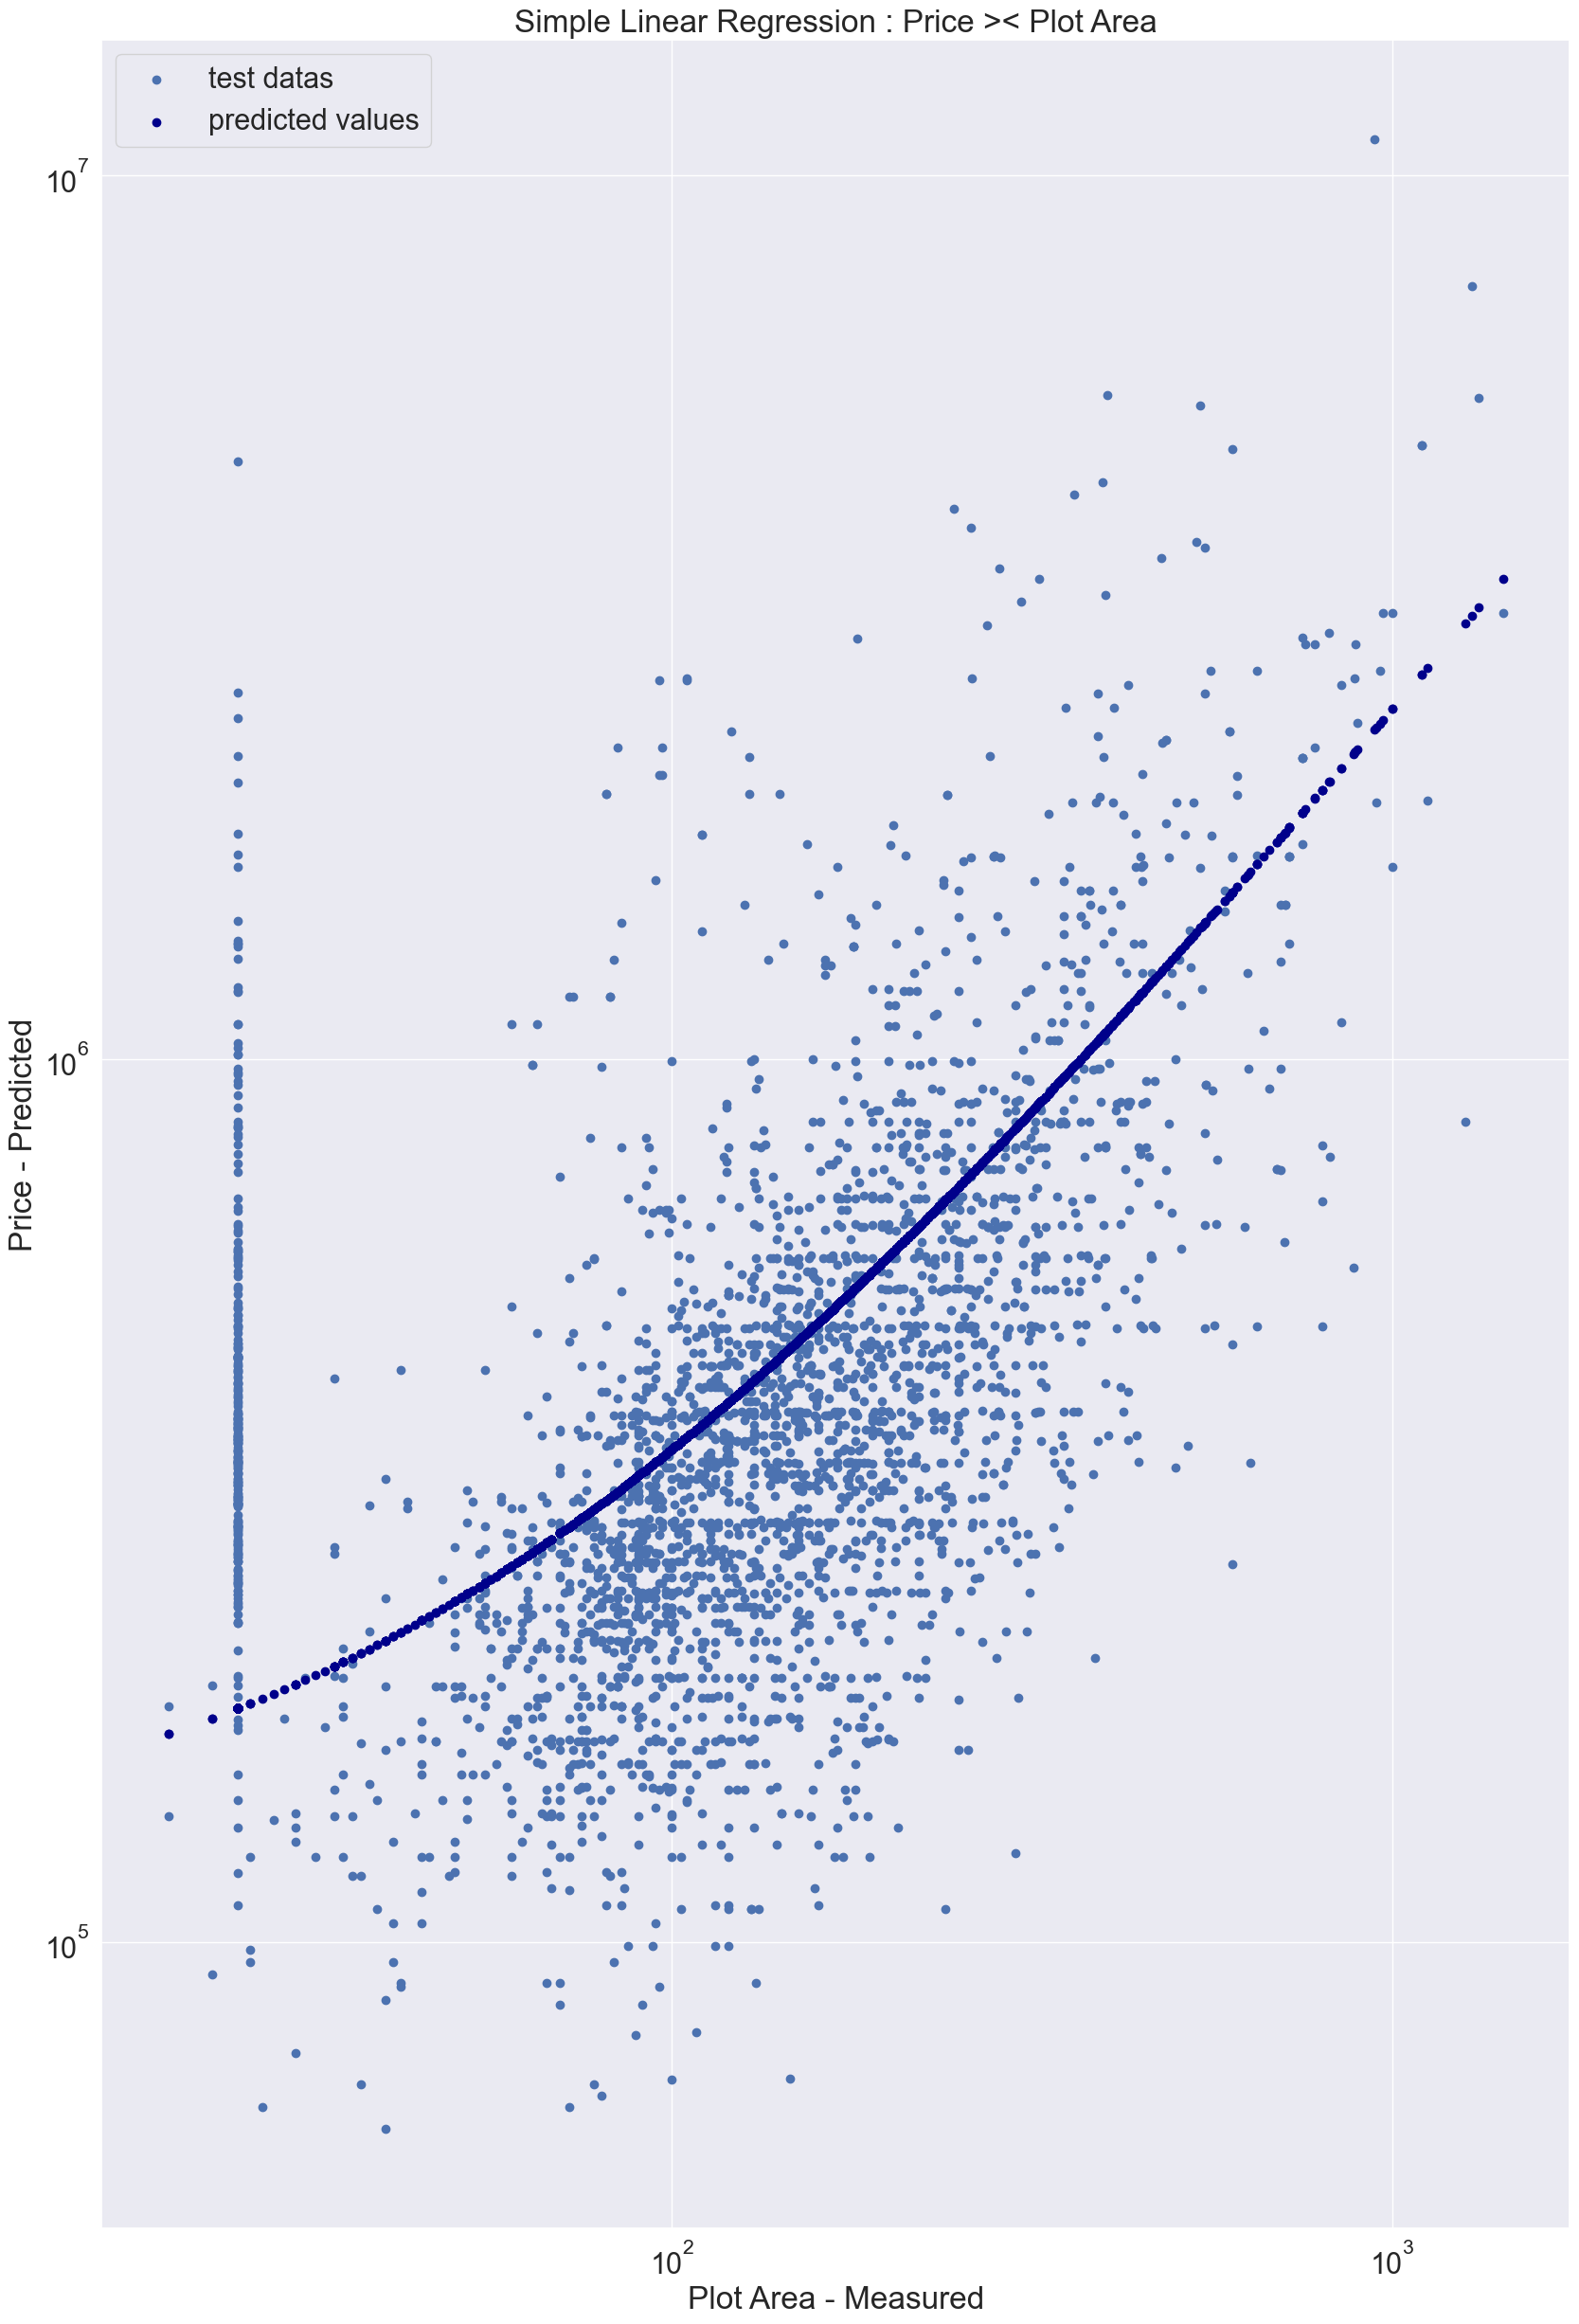

This Linear Regression Model is 33.59252574644598 percent accurate


In [305]:
# variables to use
X = dataset_numerical.drop("price", axis=1).values
y = dataset_numerical["price"].values

# reshape variables
X_plotarea = X[:,2].reshape(-1,1)
y_true = y.reshape(-1,1)


# TRAINING MODEL

## Split dataset

X_train, X_test, y_train, y_test = train_test_split(X_plotarea, y_true, test_size=0.30, random_state=42)

## fitting training
reg = LinearRegression()
reg.fit(X_train, y_train)

# testing model
X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_pred = reg.predict(X_test)

# visualize predictions
plt.scatter(X_test, y_test, label="test datas")
plt.scatter(X_test, y_pred, color="darkblue", label="predicted values")
plt.title("Simple Linear Regression : Price >< Plot Area")
plt.xlabel("Plot Area - Measured")
plt.ylabel("Price - Predicted")
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

# EVALUATION
r_squared_score = reg.score(X_test, y_test)
print(f"This Linear Regression Model is {r_squared_score*100} percent accurate")

# ## N-fold Cross-Validation
# cv_fold = 5
# cv_result_mean = np.mean(cross_val_score(reg, X_plotarea, y_true, cv=cv_fold))
# print(f"After passing through {cv_fold}-fold Cross Validation, this Linear Regression Model is {cv_result_mean*100} percent accurate")

## PRICE >< PLOT_AREA THROUGH CROSS-VALIDATED SIMPLE LINEAR REGRESSION


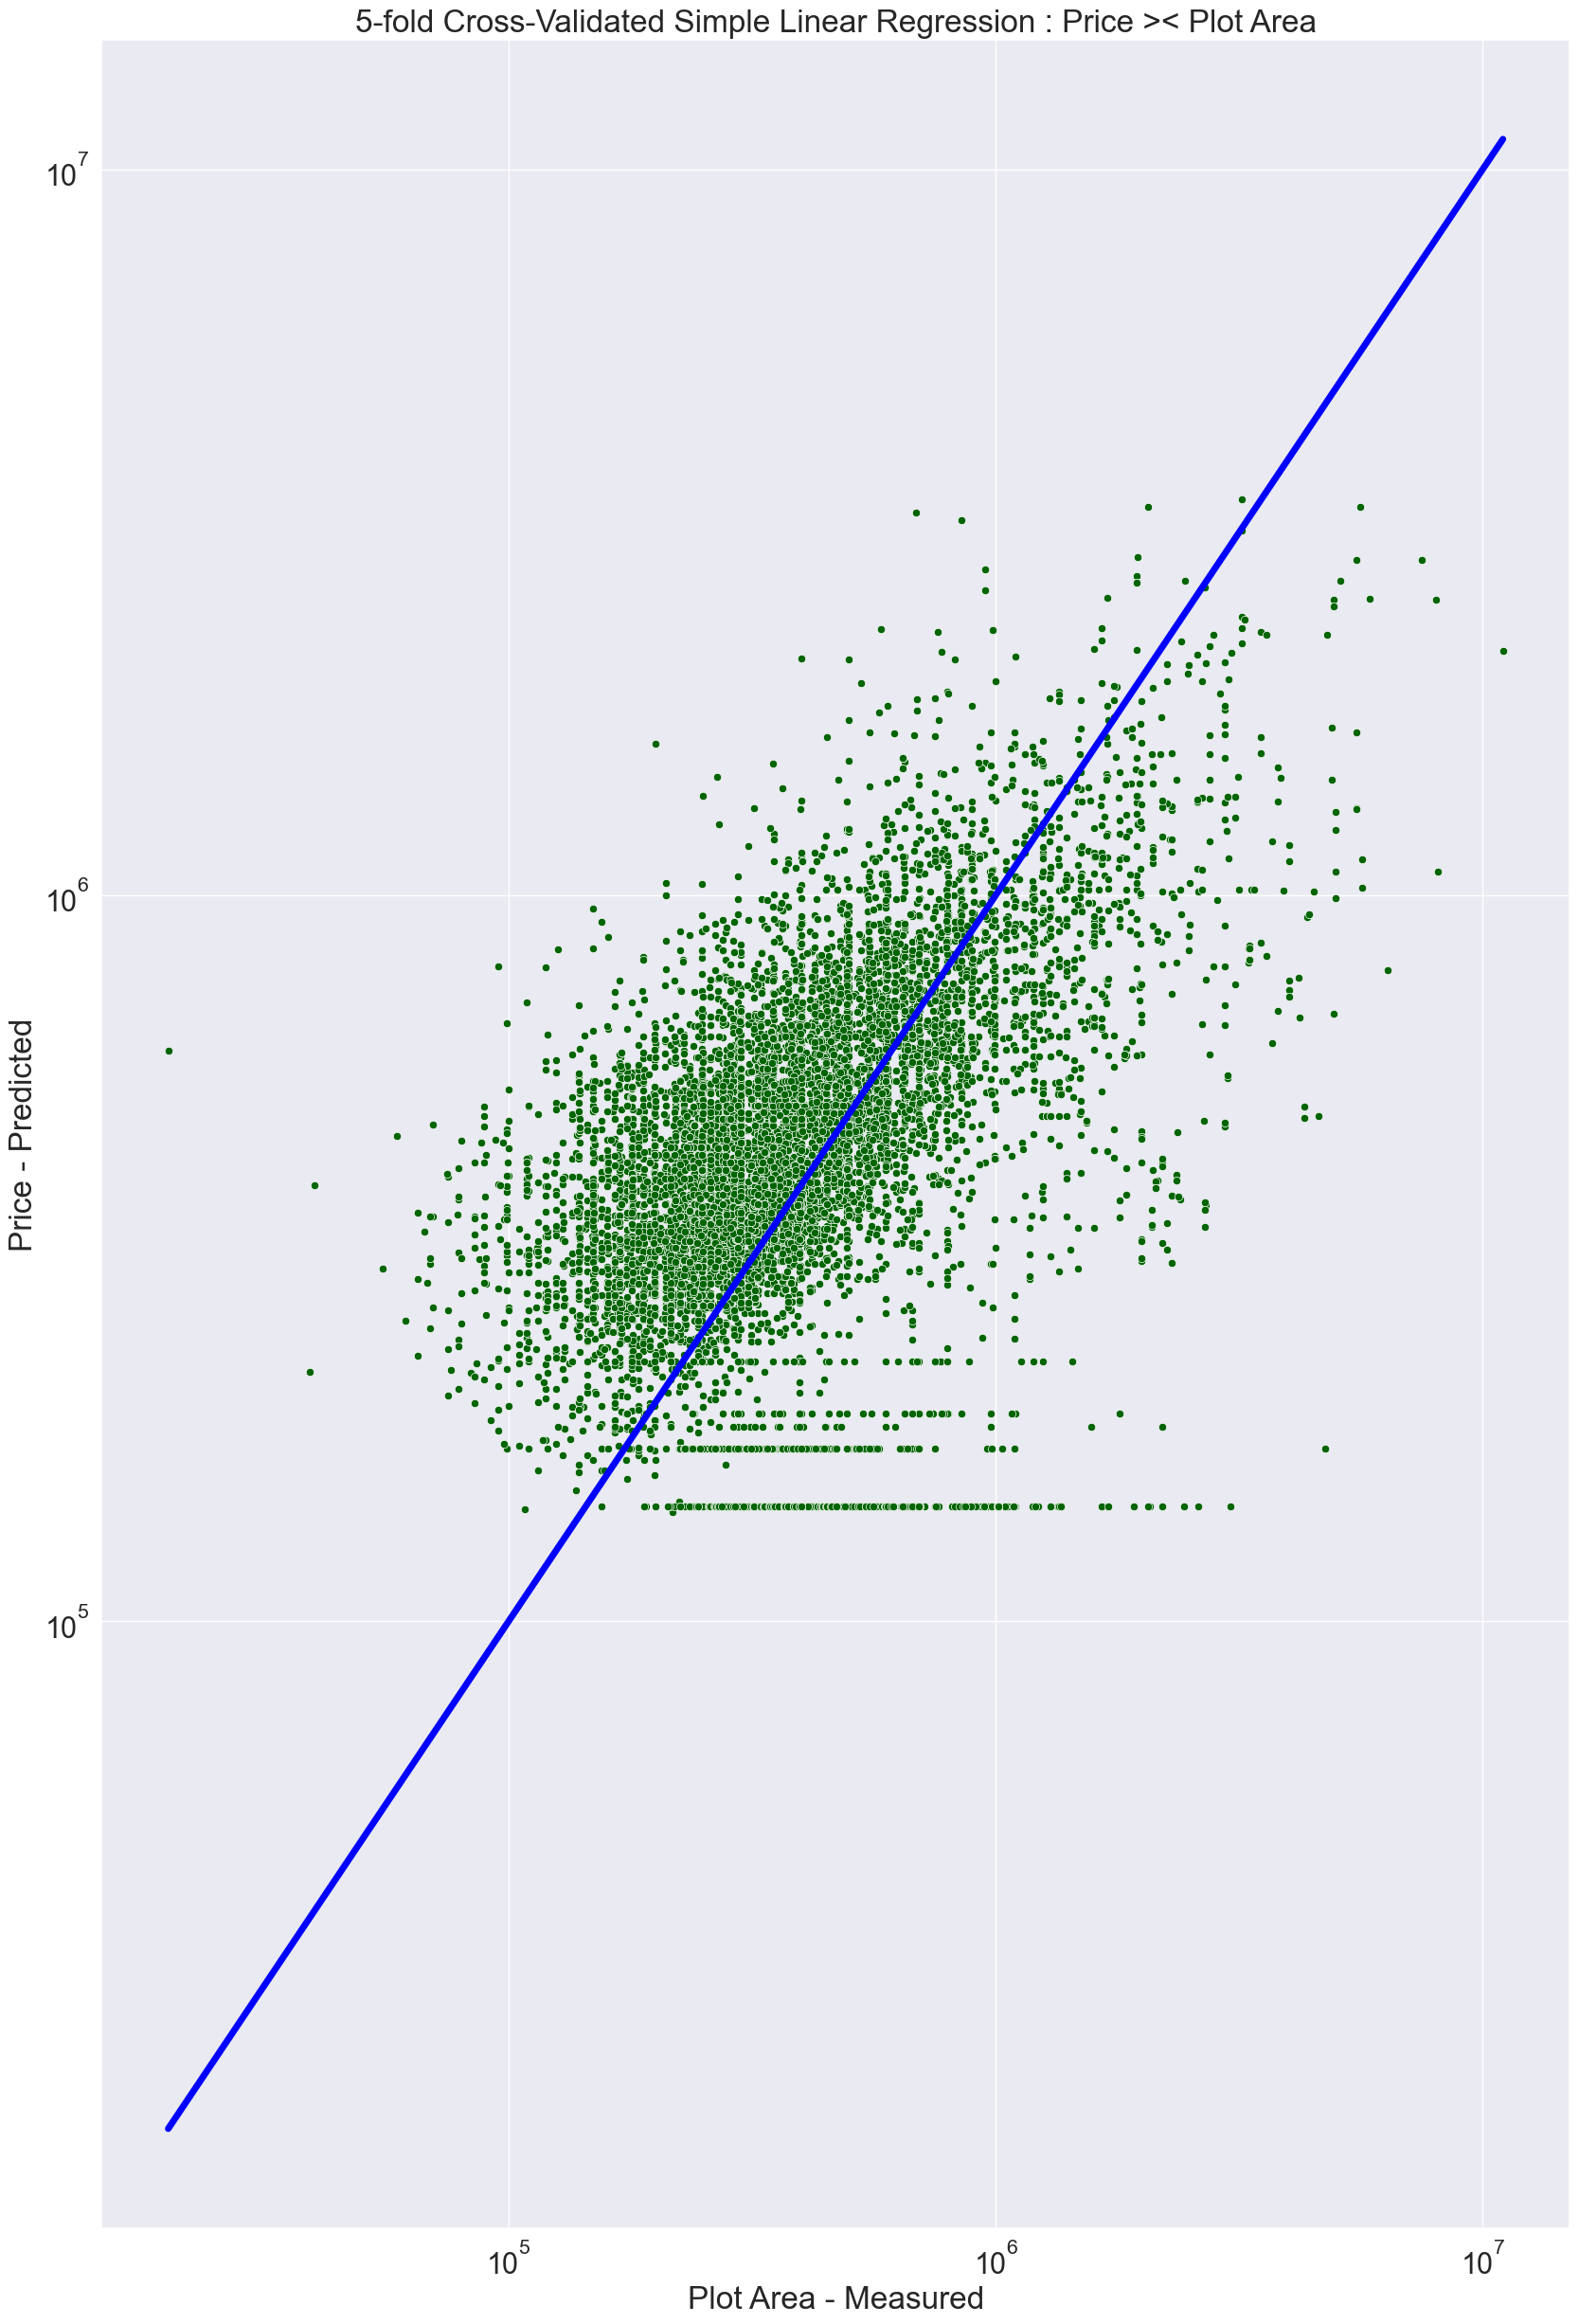

This 5-fold Cross-Validated Simple Linear Regression is 33.59252574644598 percent accurate


In [306]:
# variables to use
X = dataset_numerical.drop("price", axis=1).values
y = dataset_numerical["price"].values

# reshape variables
X_plotarea = X[:,2].reshape(-1,1)
y_true = y.reshape(-1,1)


reg_lr = LinearRegression()

cv_fold = 5

# Cross-Validated Prediction
cv_y_pred = cross_val_predict(reg_lr, X_plotarea, y_true, cv=cv_fold)

# visualise the prediction
sns.scatterplot(x=y_true.flatten(), y=cv_y_pred.flatten(), color="darkgreen")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color="blue", lw=5)
plt.title(f"{cv_fold}-fold Cross-Validated Simple Linear Regression : Price >< Plot Area")
plt.xlabel("Plot Area - Measured")
plt.ylabel("Price - Predicted")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Evaluation
cv_score_mean = np.mean(cross_val_score(reg_lr, X_plotarea, y_true, cv=cv_fold))
print(f"This {cv_fold}-fold Cross-Validated Simple Linear Regression is {r_squared_score*100} percent accurate")

## PRICE >< PLOT_AREA THROUGH CROSS-VALIDATED RIDGE REGRESSION (RIDGECV)

Best alpha: 10.0
Ridge score: 0.33594669926974696


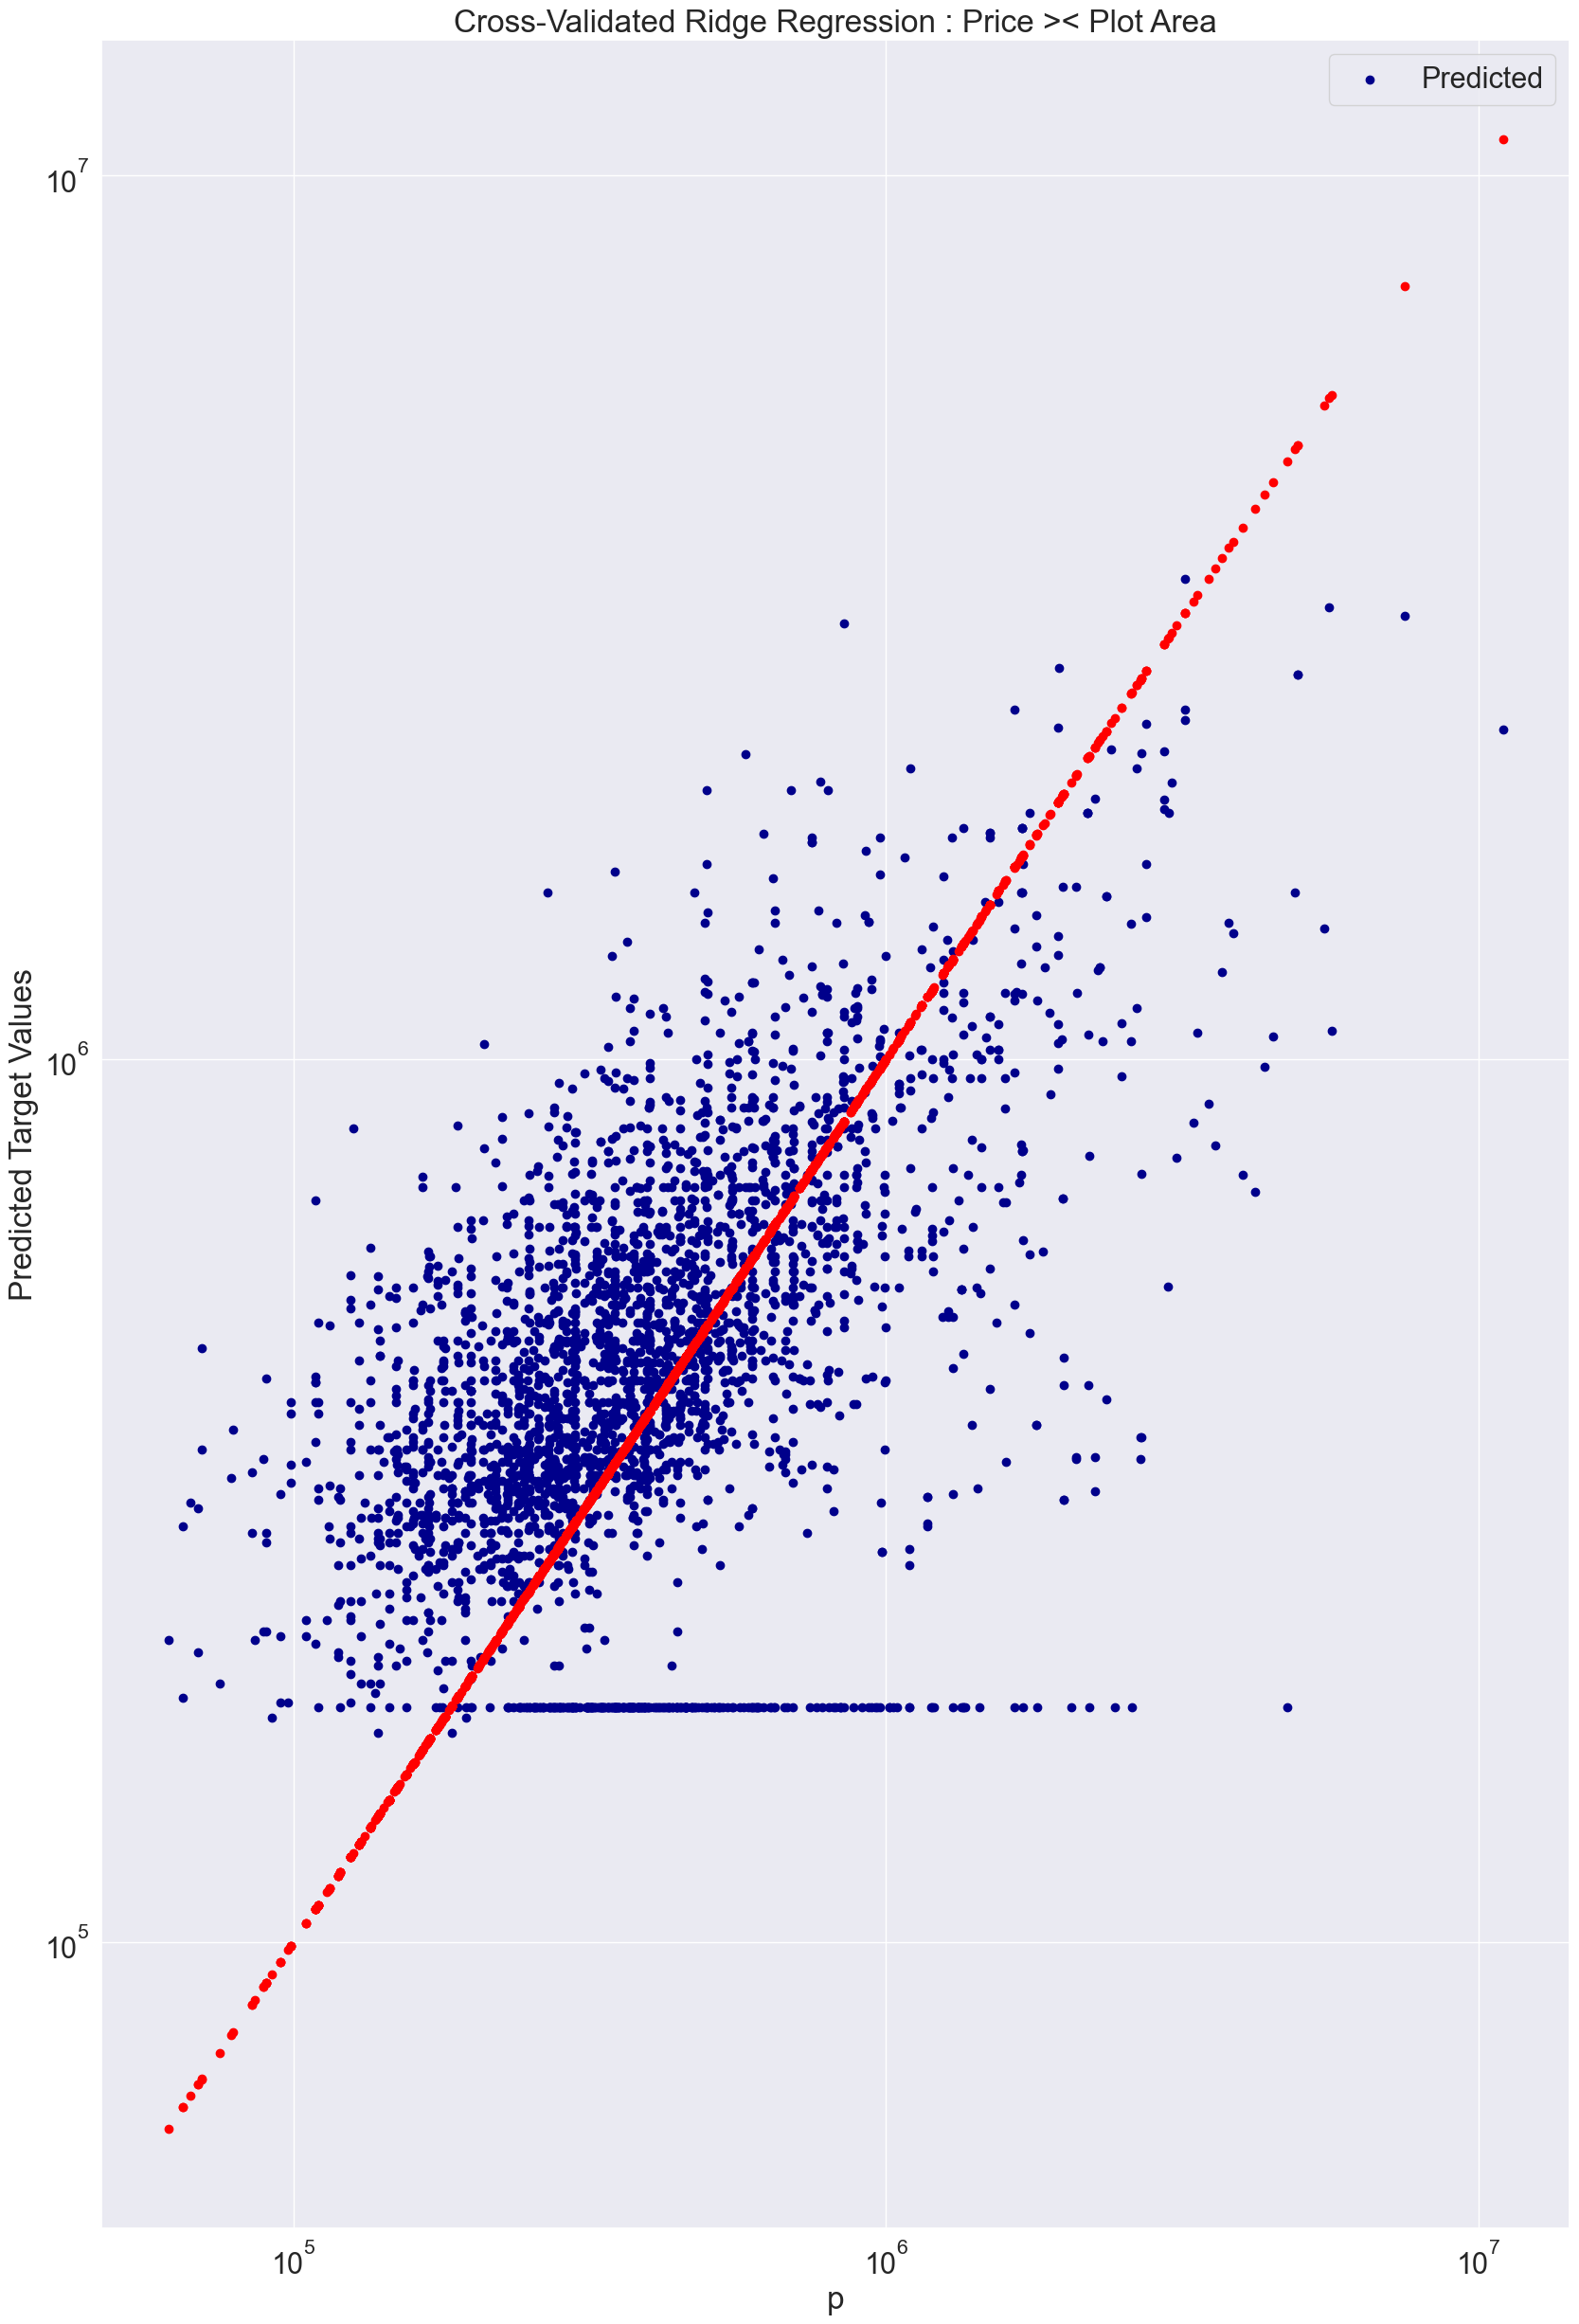

In [307]:
# Create the pipeline with the StandardScaler and RidgeCV
cv_fold = 6
ridge_pipeline = make_pipeline(
    StandardScaler(),                   # Normalize the data
    RidgeCV(alphas=[0.1, 1.0, 10.0], cv=cv_fold)   # Perform cross-validated ridge regression
)

# Fit the pipeline to the training data
ridge_pipeline.fit(X_train, y_train)

# Predict on the test data
ridged_y_pred = ridge_pipeline.predict(X_test)

# Get the best alpha value from the cross-validation
best_alpha = ridge_pipeline.named_steps['ridgecv'].alpha_

# Get the score of the best ridge model
ridged_score = ridge_pipeline.score(X_test, y_test)

print(f"Best alpha: {best_alpha}")
print(f"Ridge score: {ridged_score}")


# VISUALIZE PREDICTION

plt.scatter(y_test, ridged_y_pred, color='darkblue', label='Predicted')
plt.scatter(y_test, y_test, color='red')  # Diagonal line (perfect prediction)
plt.xlabel('p')
plt.ylabel('Predicted Target Values')
plt.title('Cross-Validated Ridge Regression : Price >< Plot Area')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



## PRICE >< PLOT_AREA THROUGH HUBERREGRESSOR

c:\Users\dimas\Desktop\BECODE\PROJECTS\project_immo_regression\dev_env\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dimas\Desktop\BECODE\PROJECTS\project_immo_regression\dev_env\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dimas\Desktop\BECODE\PROJECTS\project_immo_regression\dev_env\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dimas\Desktop\BECODE\PROJECTS\project_immo_regression\d

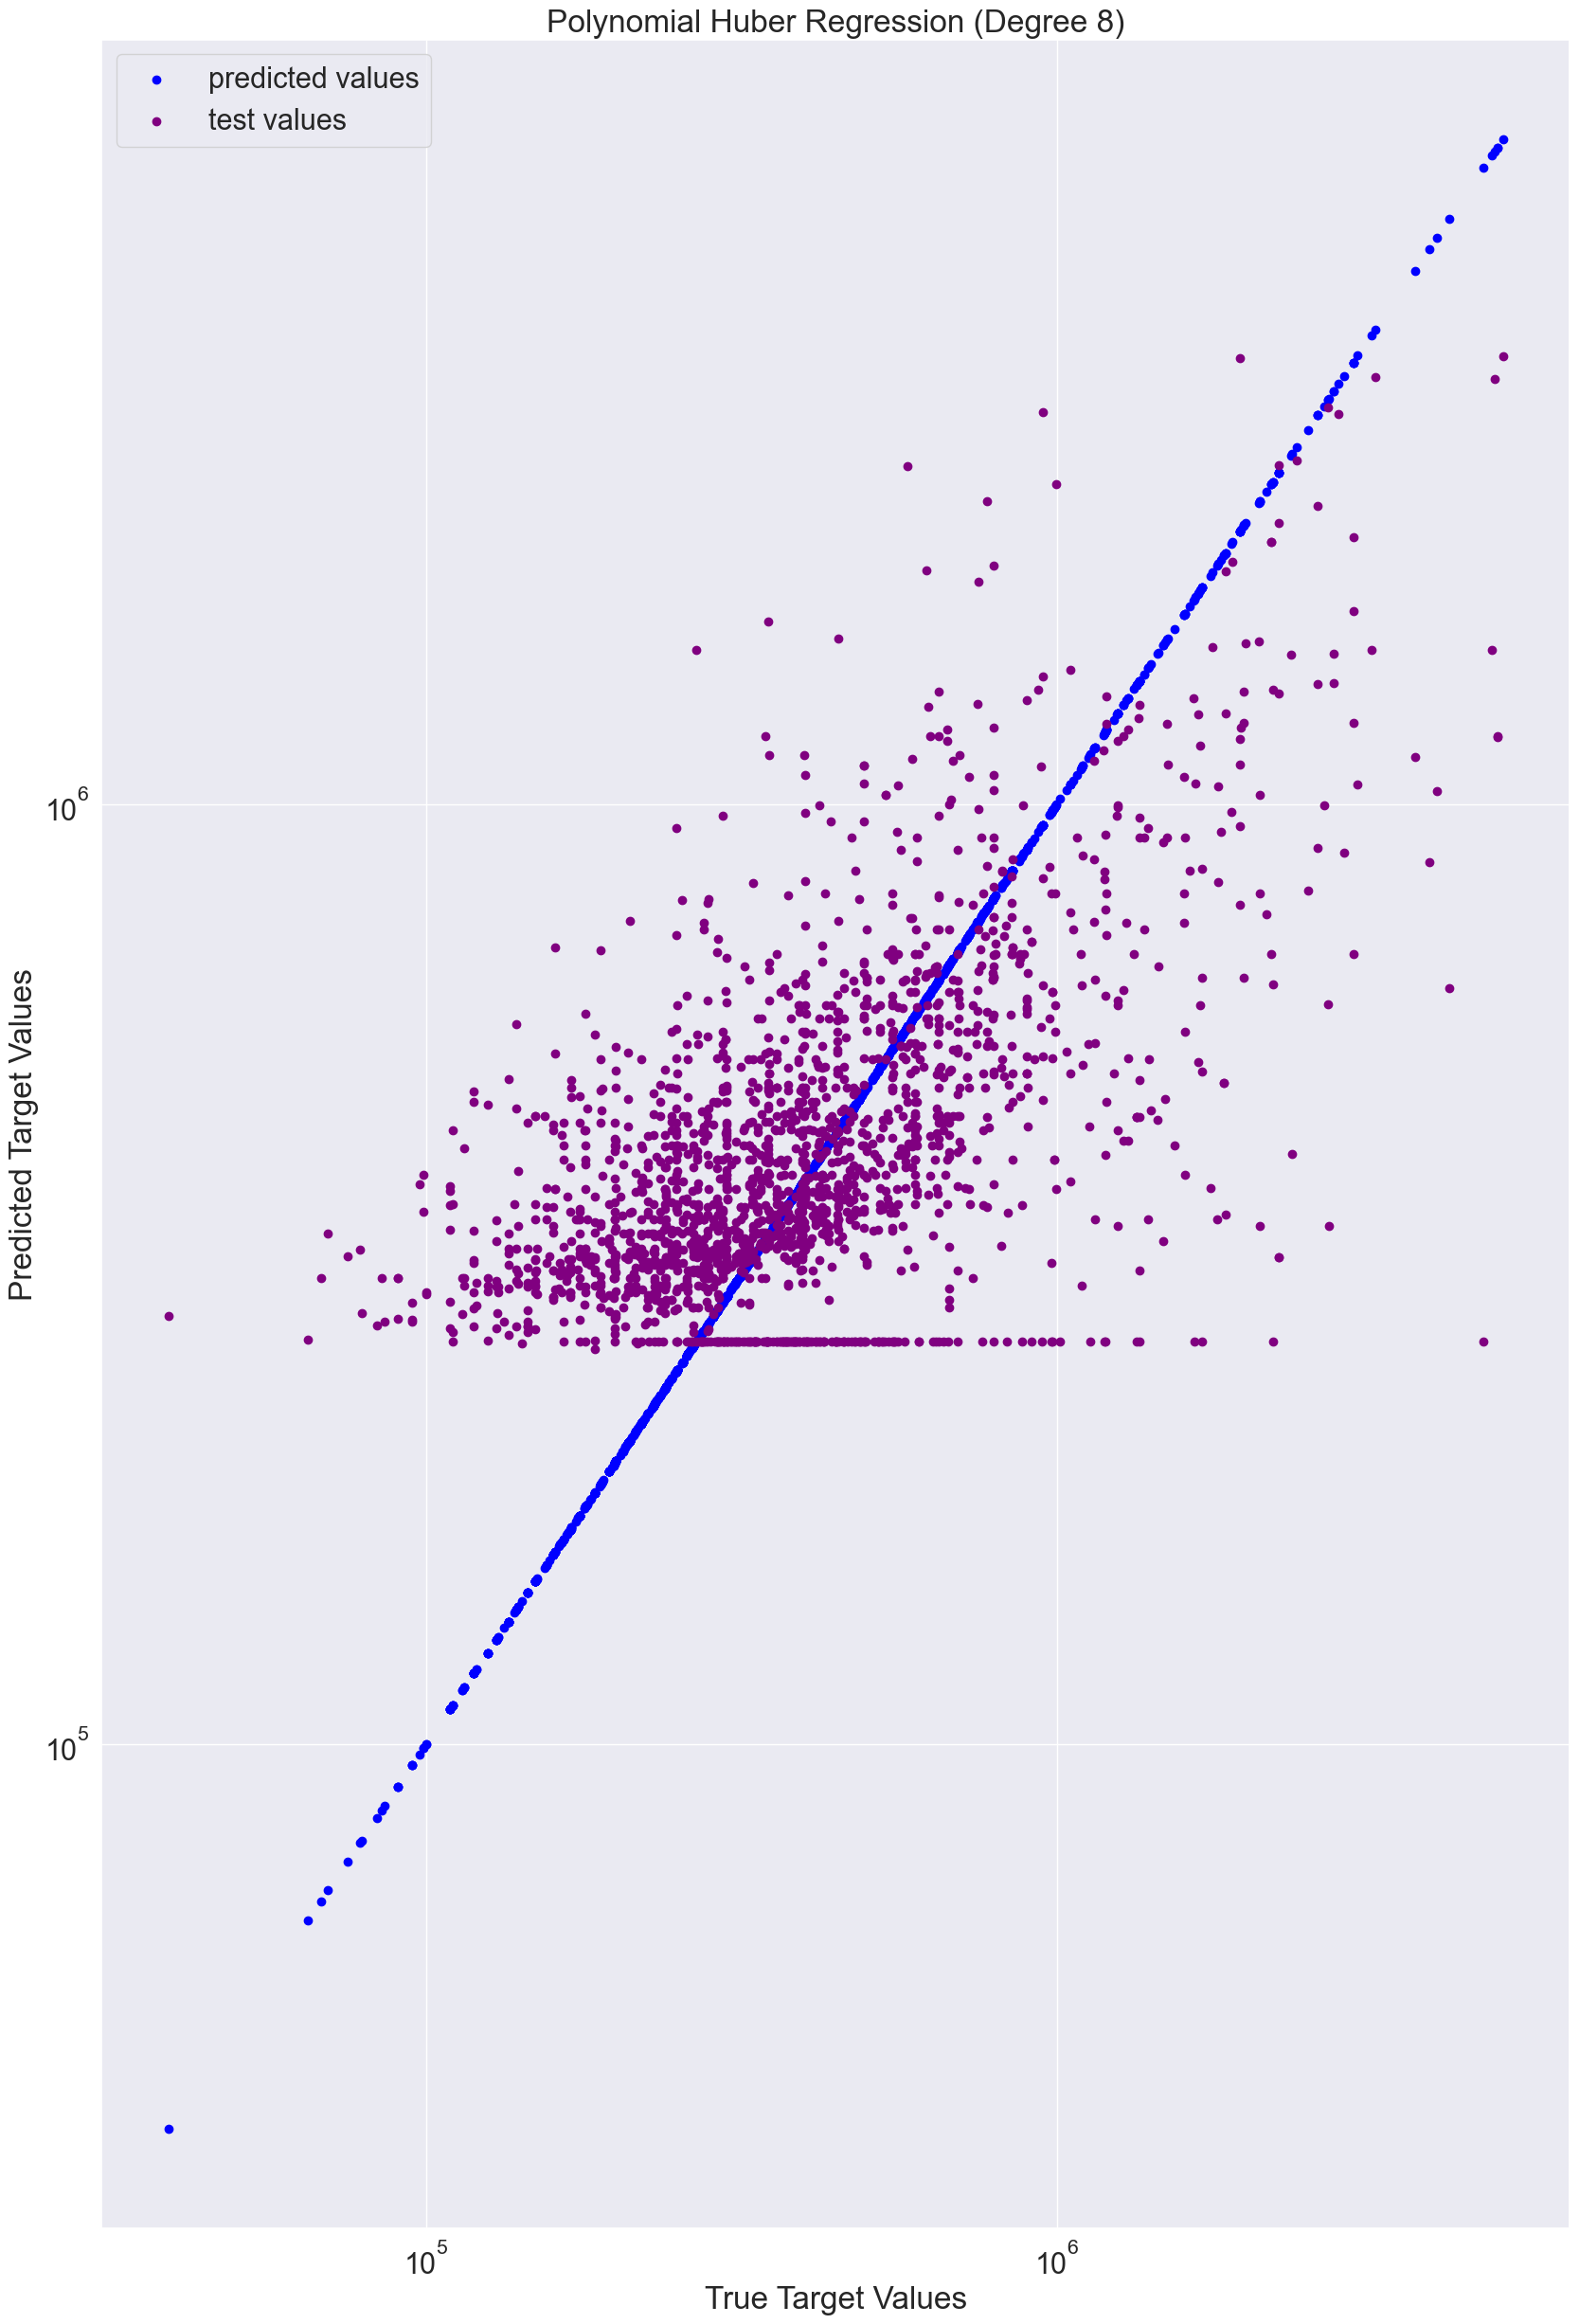

Cross-Validated Huber Regression R^2 Scores: [0.37383751 0.30993487 0.34709023 0.34546864 0.31381298]
Mean R^2 Score: 0.34 +/- 0.02


In [342]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming you have already loaded the dataset and created dataset_numerical

# Variables to use
X = dataset_numerical.drop("price", axis=1).values
y = dataset_numerical["price"].values

# Reshape variables
X_plotarea = X[:, 2].reshape(-1, 1)
y_true = y.reshape(-1, 1)

# Specify degree of 2 for polynomial regression model
degree = 8

# Create a pipeline with PolynomialFeatures, StandardScaler, and HuberRegressor
poly_huber_pipeline = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    HuberRegressor(epsilon=2.5)  # You can adjust the epsilon value as needed
)

# Split the variables
X_train, X_test, y_train, y_test = train_test_split(X_plotarea, y_true, test_size=0.20, random_state=30000, shuffle=True)

# Perform cross-validated Huber regression with polynomial features
cv_fold = 5
cv_scores = cross_val_score(poly_huber_pipeline, X_train, y_train, cv=cv_fold, scoring='r2')

# Fit poly_huber_pipeline
poly_huber_pipeline.fit(X_train, y_train)

# Determine y_pred
y_pred = poly_huber_pipeline.predict(X_test)

# Visualize predictions
# plt.scatter(X_test, y_test, color='green', label="test values")
# plt.scatter(X_test, y_pred, color="red", label="predicted values")
plt.scatter(y_test, y_test, color='blue', label="predicted values")  # Diagonal line (perfect prediction)
plt.scatter(y_test, y_pred, color = "purple", label="test values")
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title(f'Polynomial Huber Regression (Degree {degree})')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# Calculate mean and standard deviation of cross-validated scores
cv_mean_score = np.mean(cv_scores)
cv_std_score = np.std(cv_scores)

print(f"Cross-Validated Huber Regression R^2 Scores: {cv_scores}")
print(f"Mean R^2 Score: {cv_mean_score:.2f} +/- {cv_std_score:.2f}")


## PRICE >< PLOT_AREA THROUGH N-DEGREE POLYNOMIAL REGRESSION

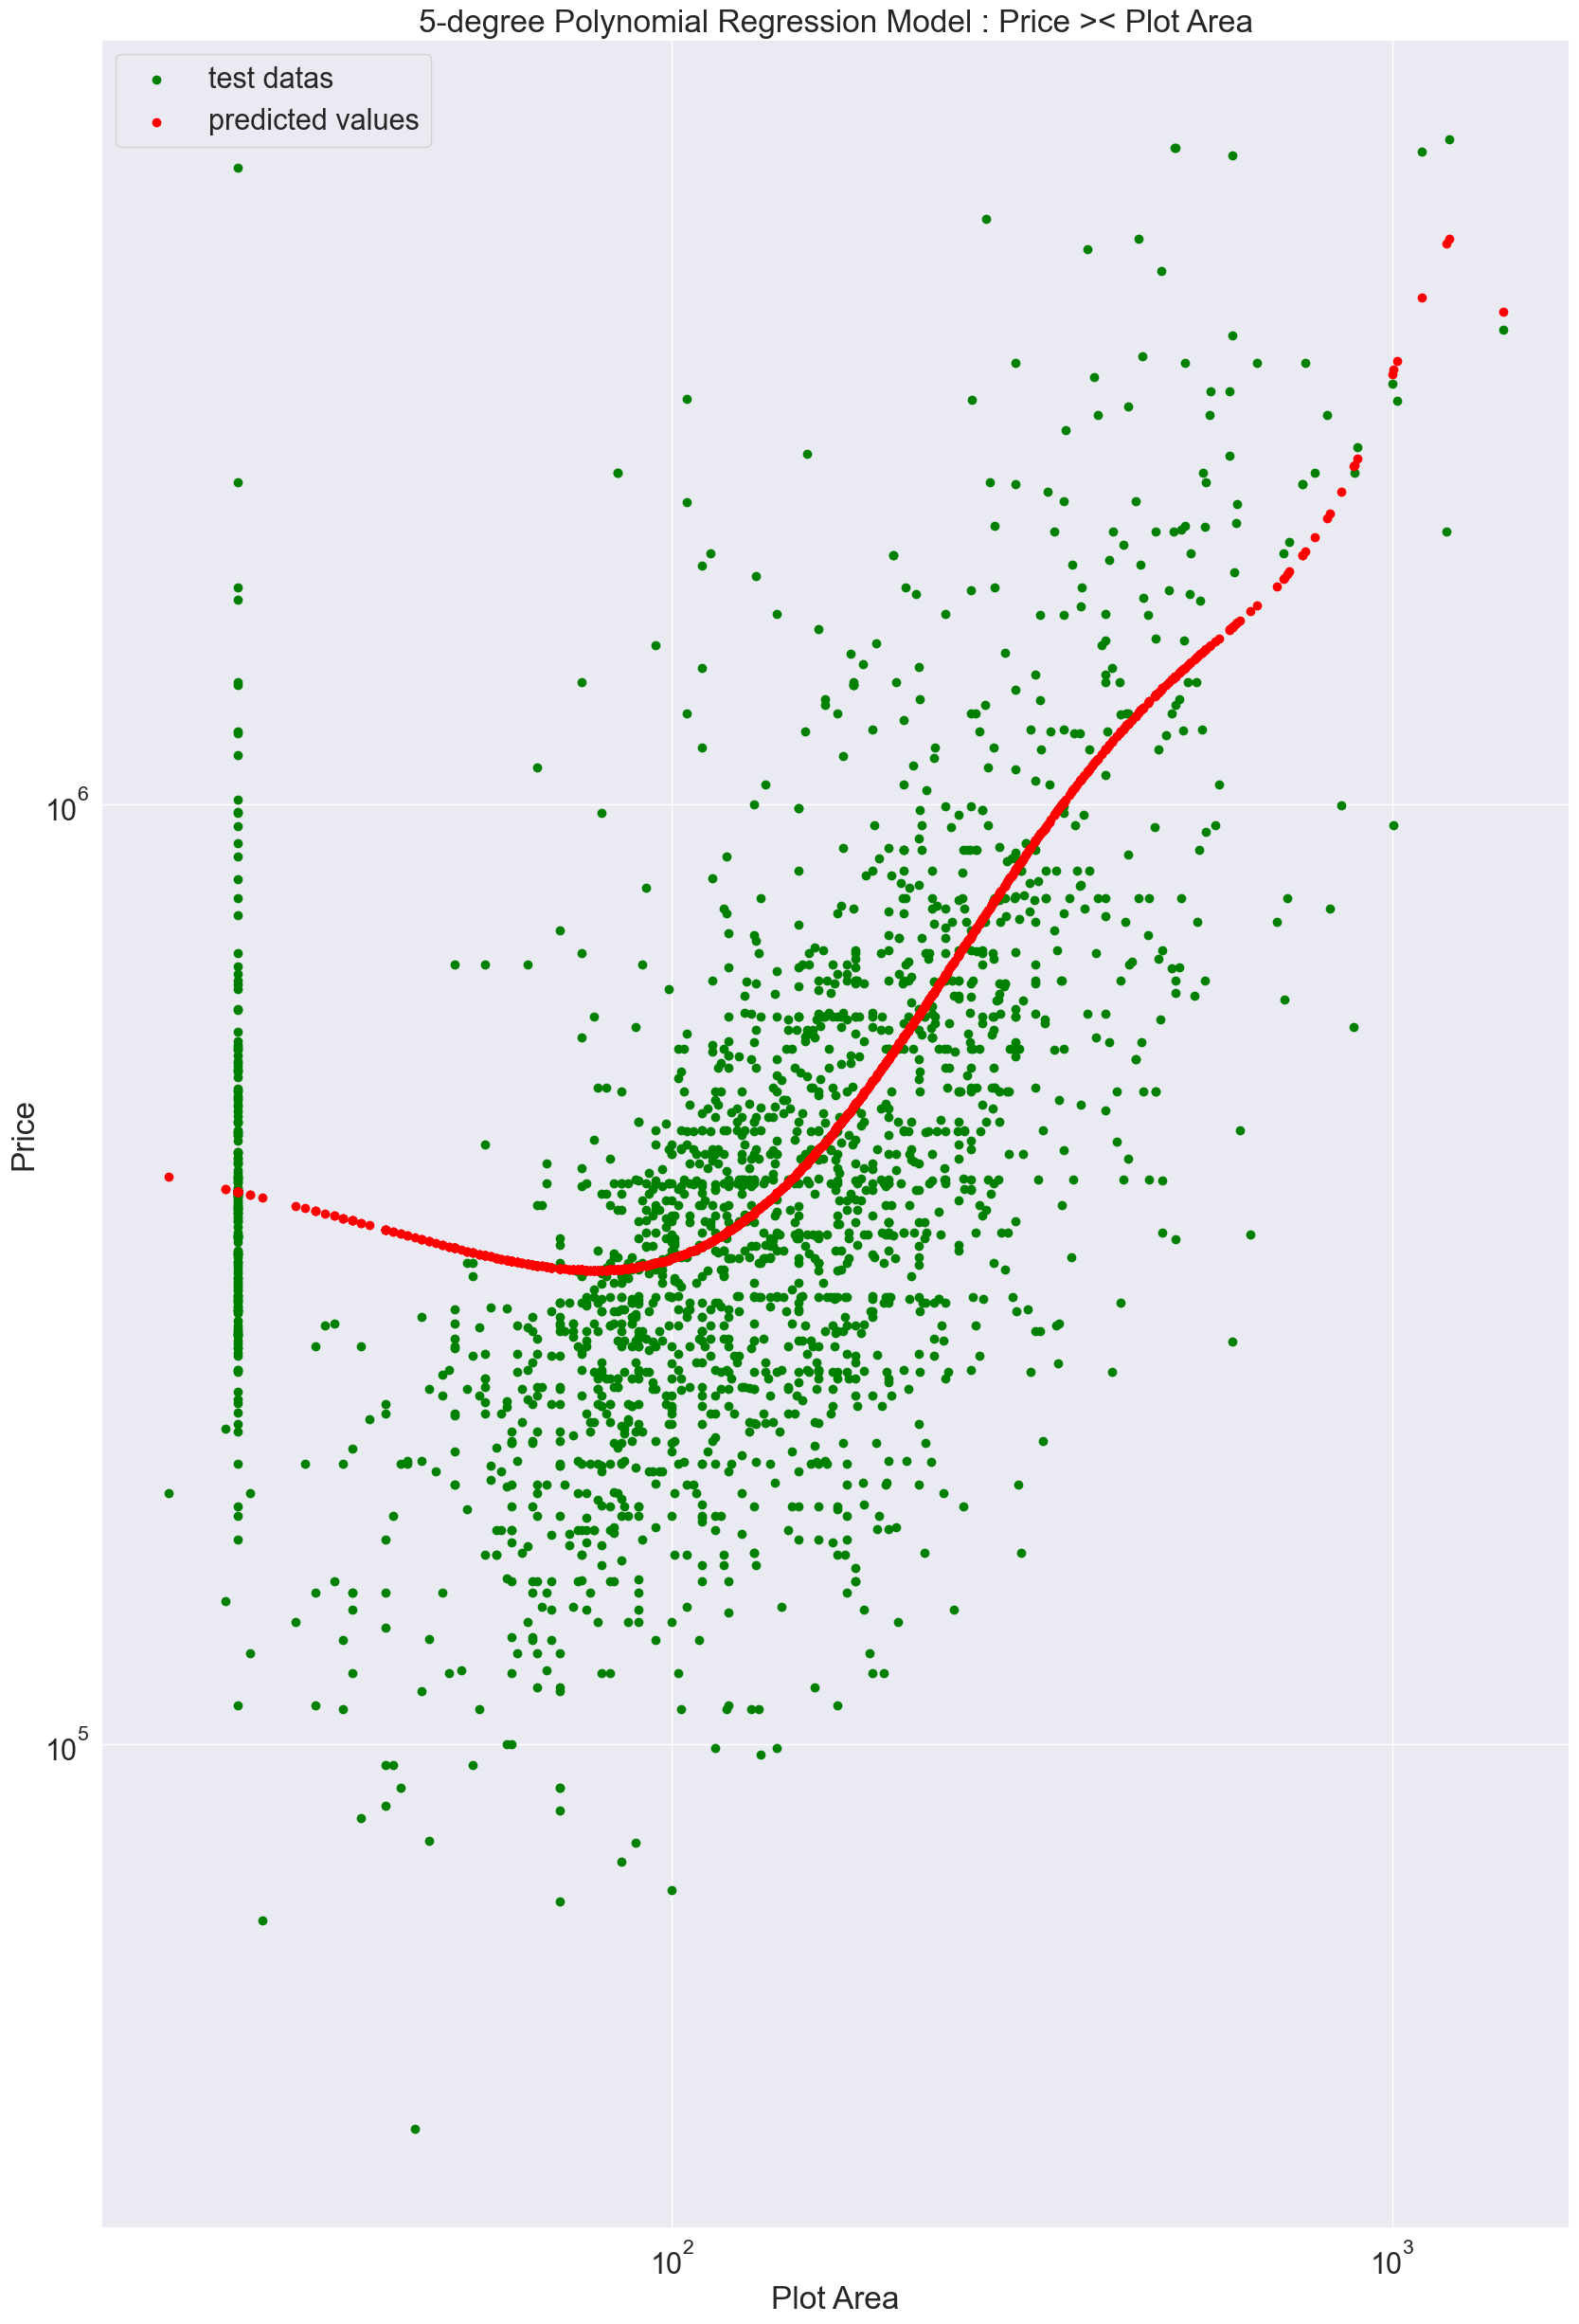

This 5-degree Polynomial Regression Model degree is 39.976101897177465 percent accurate


In [311]:

# variables to use
X = dataset_numerical.drop("price", axis=1).values
y = dataset_numerical["price"].values

# reshape variables
X_plotarea = X[:,2].reshape(-1,1)
y_true = y.reshape(-1,1)

# specify degree of 2 for polynomial regression model
degree = 5
poly_pipeline = make_pipeline(PolynomialFeatures(
                    degree=degree, 
                    include_bias=False),
                    LinearRegression()) 

# split the variable
X_train, X_test, y_train, y_test = train_test_split(X_plotarea, y_true, test_size=0.20, random_state=30000, shuffle=True)

# fit poly_pipeline
poly_pipeline.fit(X_train, y_train)

# determine y_pred
y_pred = poly_pipeline.predict(X_test)

# visualize predictions
plt.scatter(X_test, y_test, color='green', label='test datas')
plt.scatter(X_test, y_pred, color="red", label="predicted values")
plt.title(f"{degree}-degree Polynomial Regression Model : Price >< Plot Area")
plt.xlabel("Plot Area")
plt.ylabel("Price")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

r_squared_score = poly_pipeline.score(X_test, y_test)
print(f"This {degree}-degree Polynomial Regression Model degree is {r_squared_score*100} percent accurate")



## PRICE >< PLOT_AREA THROUGH N-DEGREE CROSS-VALIDATED POLYNOMIAL RIDGE REGRESSION

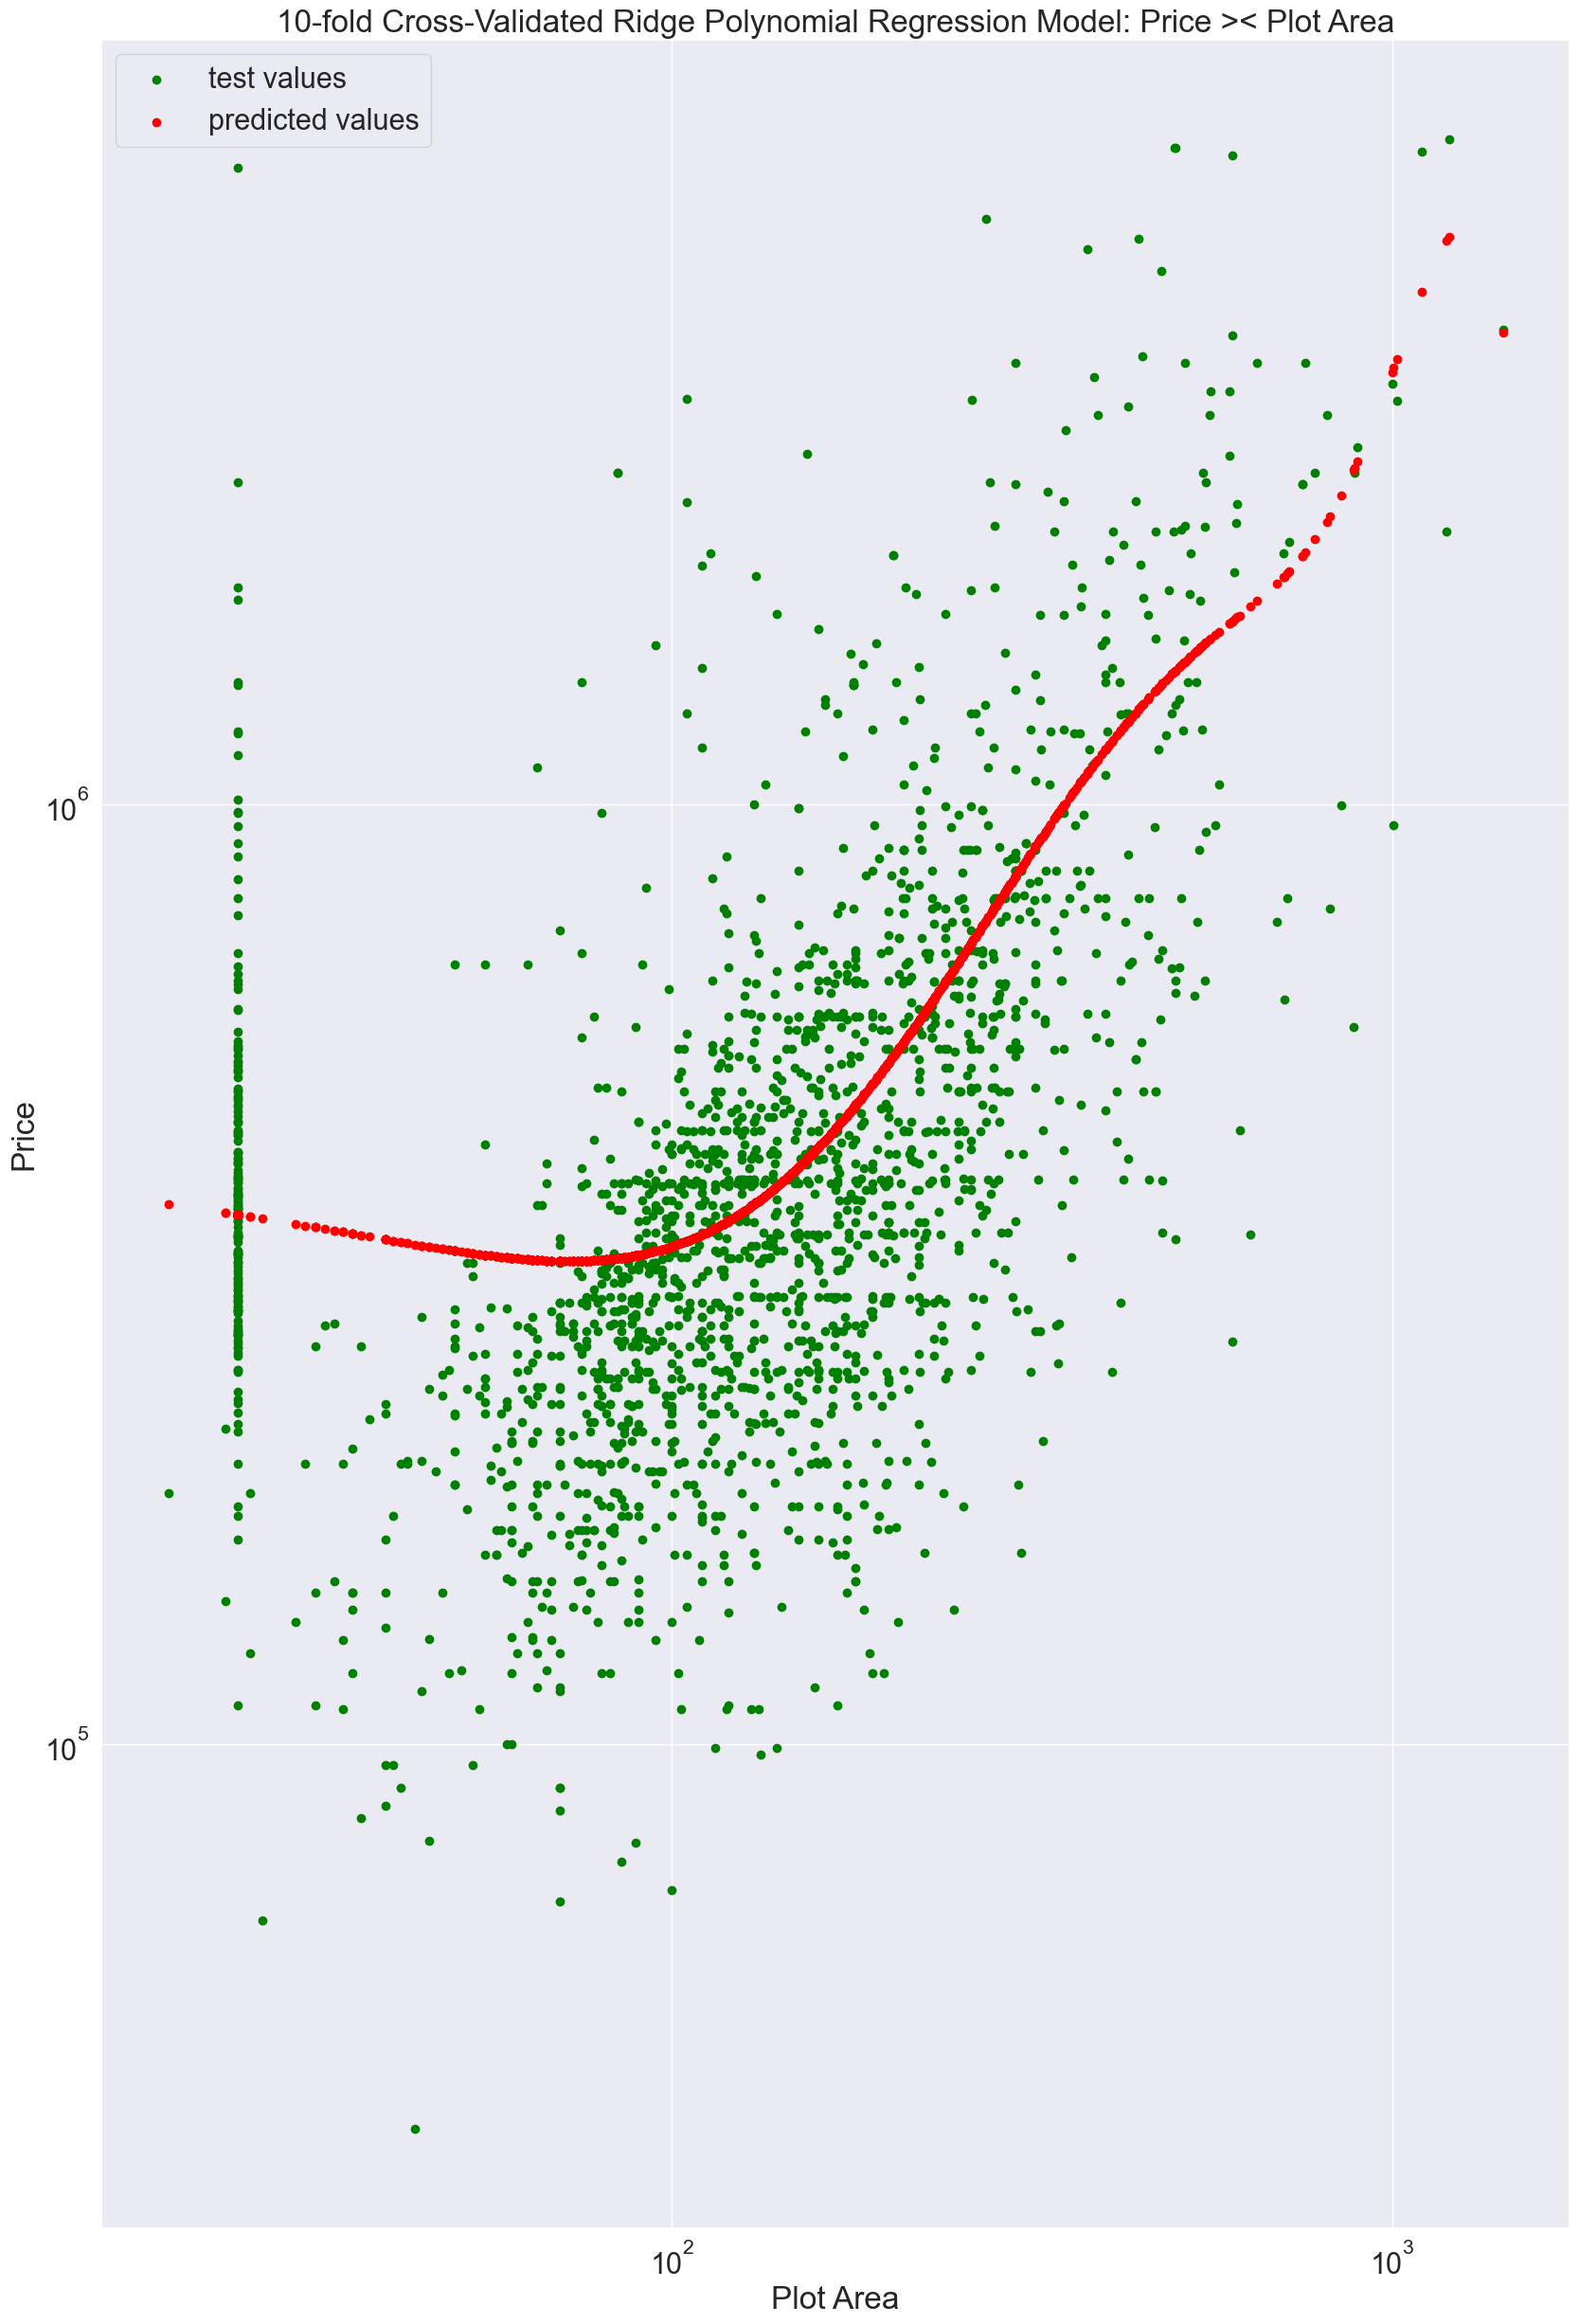

This Cross-Validated Ridge Polynomial Regression Model is 40.055742141558085 percent accurate


In [347]:
# variables to use
X = dataset_numerical.drop("price", axis=1).values
y = dataset_numerical["price"].values

# reshape variables
X_plotarea = X[:, 2].reshape(-1, 1)
y_true = y.reshape(-1, 1)

# specify degree of 2 for polynomial regression model
degree = 10
cv_fold = 10

# Create a pipeline with PolynomialFeatures, StandardScaler, and RidgeCV
poly_ridge_pipeline = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=cv_fold)  # You can specify your desired alpha values here
)

# split the variable
X_train, X_test, y_train, y_test = train_test_split(X_plotarea, y_true, test_size=0.20, random_state=30000, shuffle=True)

# fit poly_ridge_pipeline
poly_ridge_pipeline.fit(X_train, y_train)

# determine y_pred
y_pred = poly_ridge_pipeline.predict(X_test)

# visualize predictions
plt.scatter(X_test, y_test, color='green', label="test values")
plt.scatter(X_test, y_pred, color="red", label="predicted values")
plt.title(f"{cv_fold}-fold Cross-Validated Ridge Polynomial Regression Model: Price >< Plot Area")
plt.xlabel("Plot Area")
plt.ylabel("Price")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

r_squared_score = poly_ridge_pipeline.score(X_test, y_test)
print(f"This Cross-Validated Ridge Polynomial Regression Model is {r_squared_score*100} percent accurate")

## PRICE >< HABITABLE_AREA through linear regression

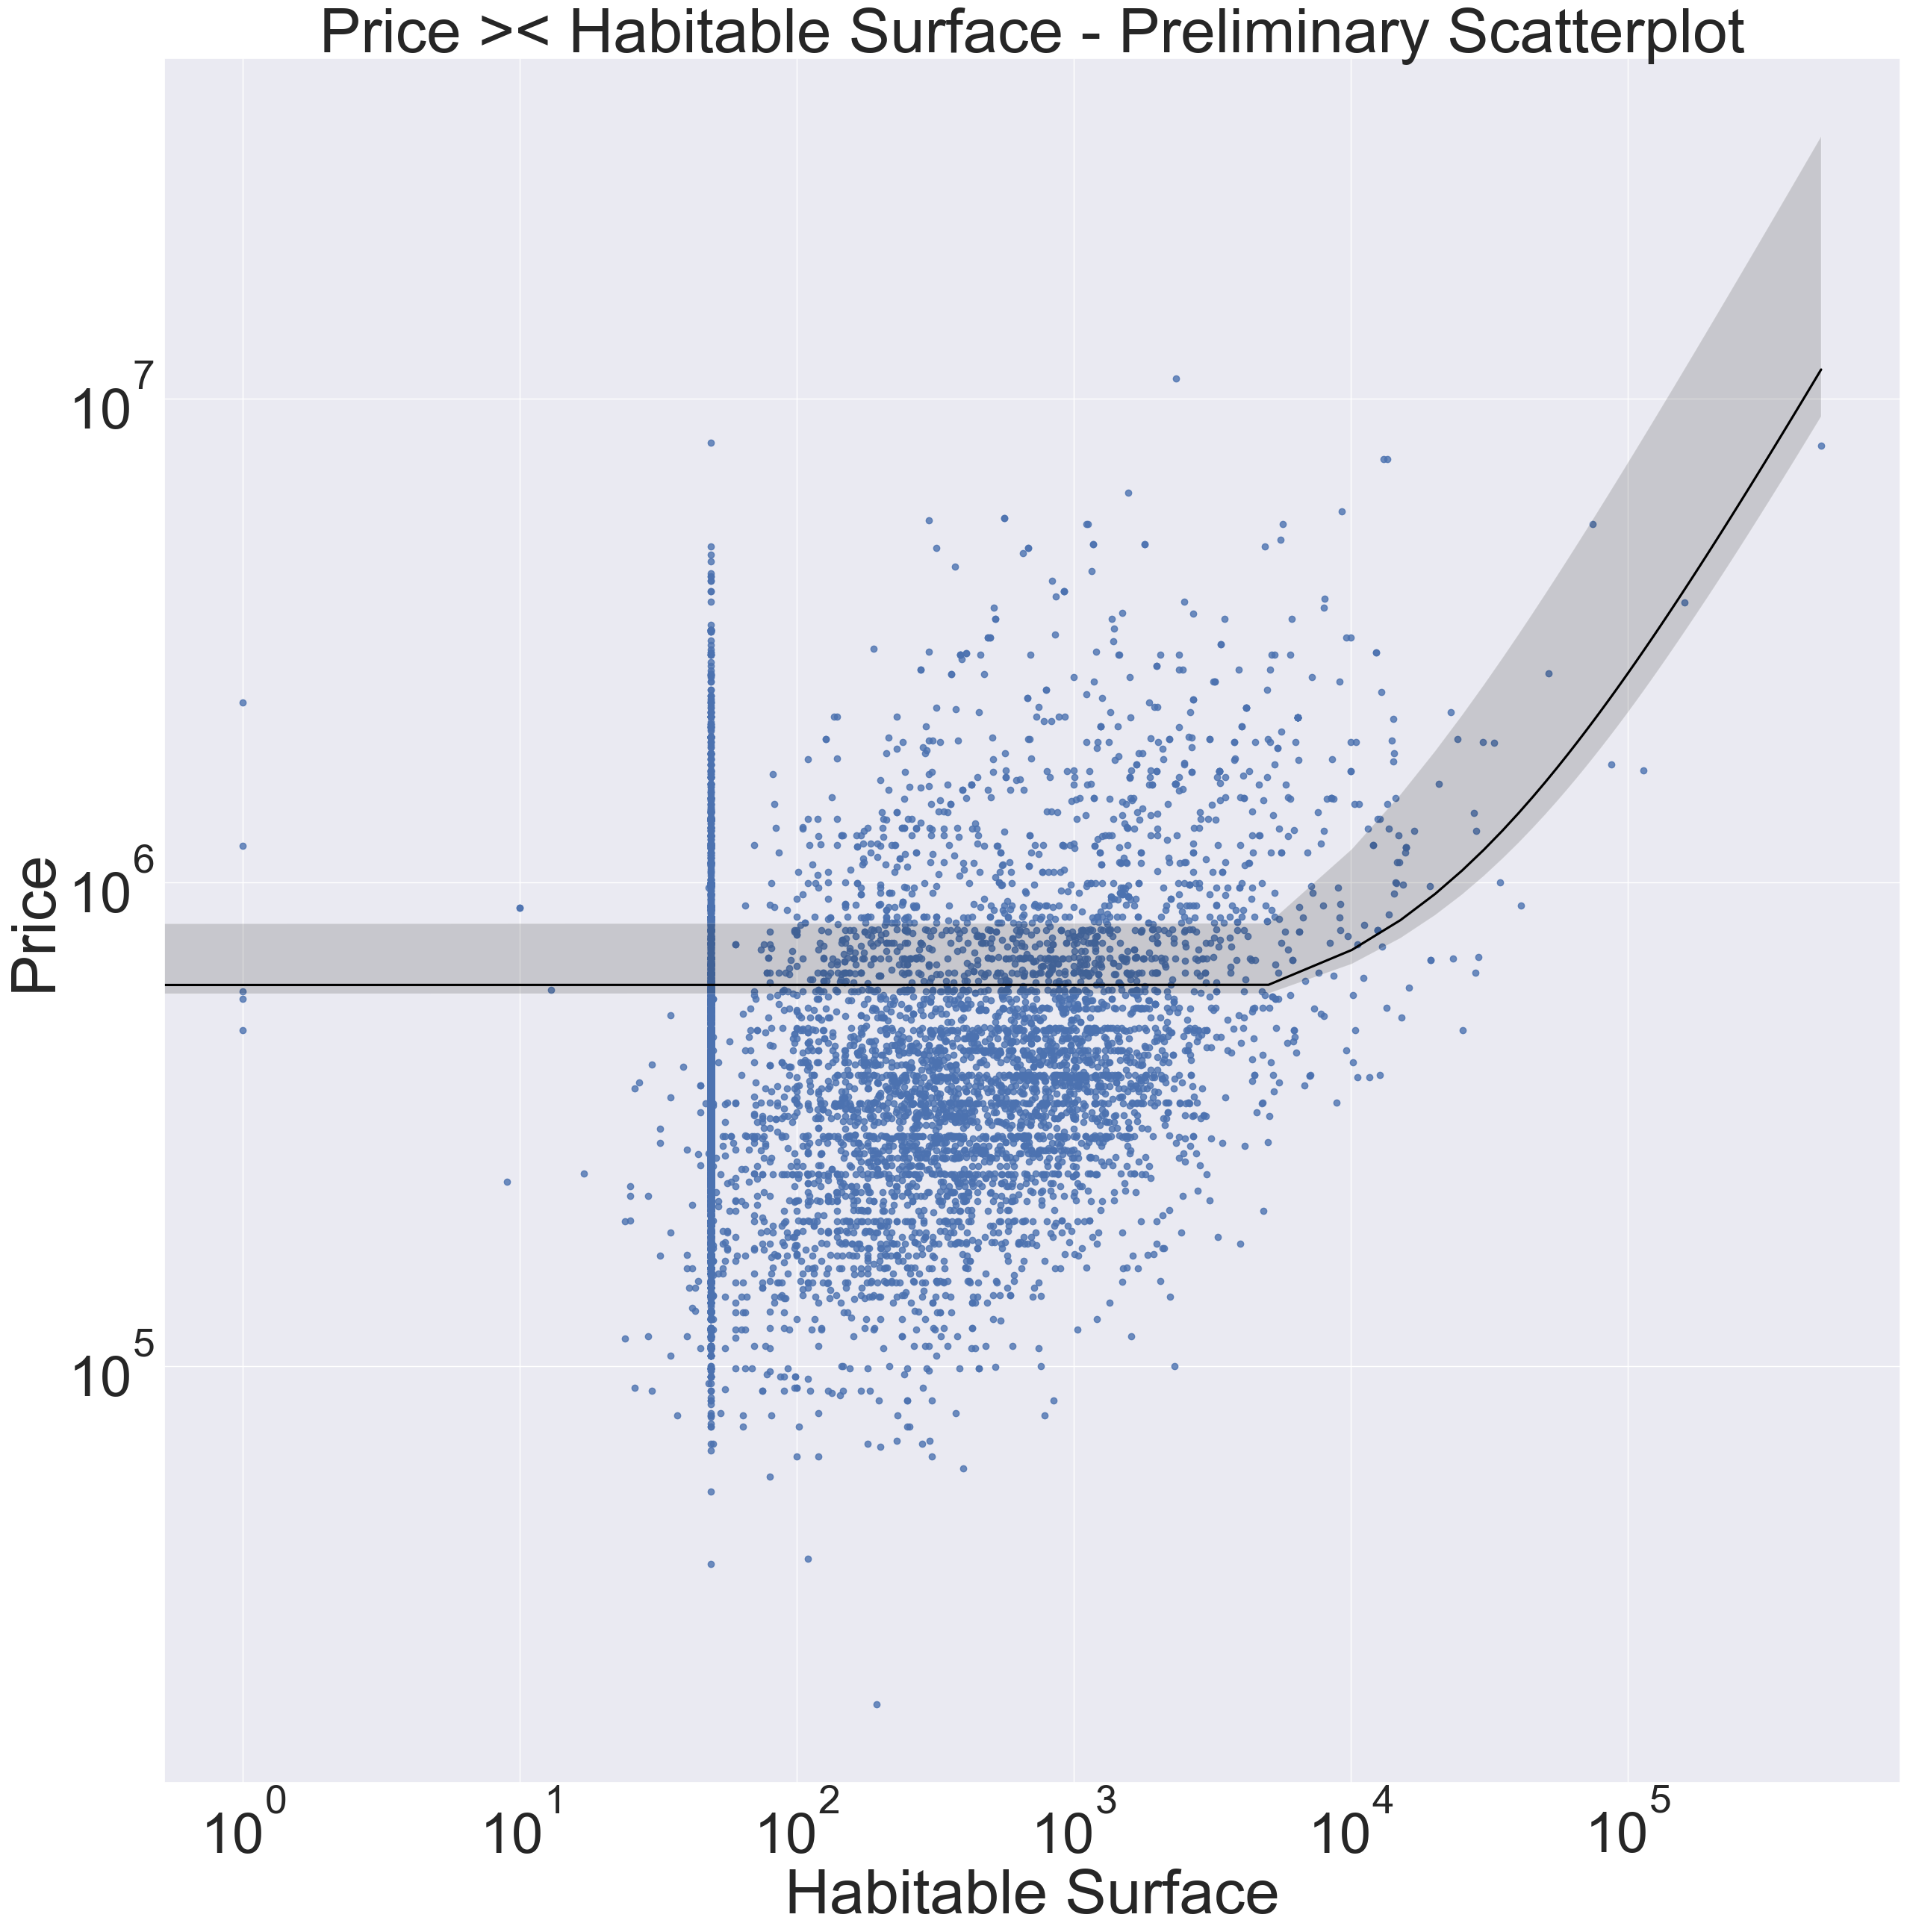

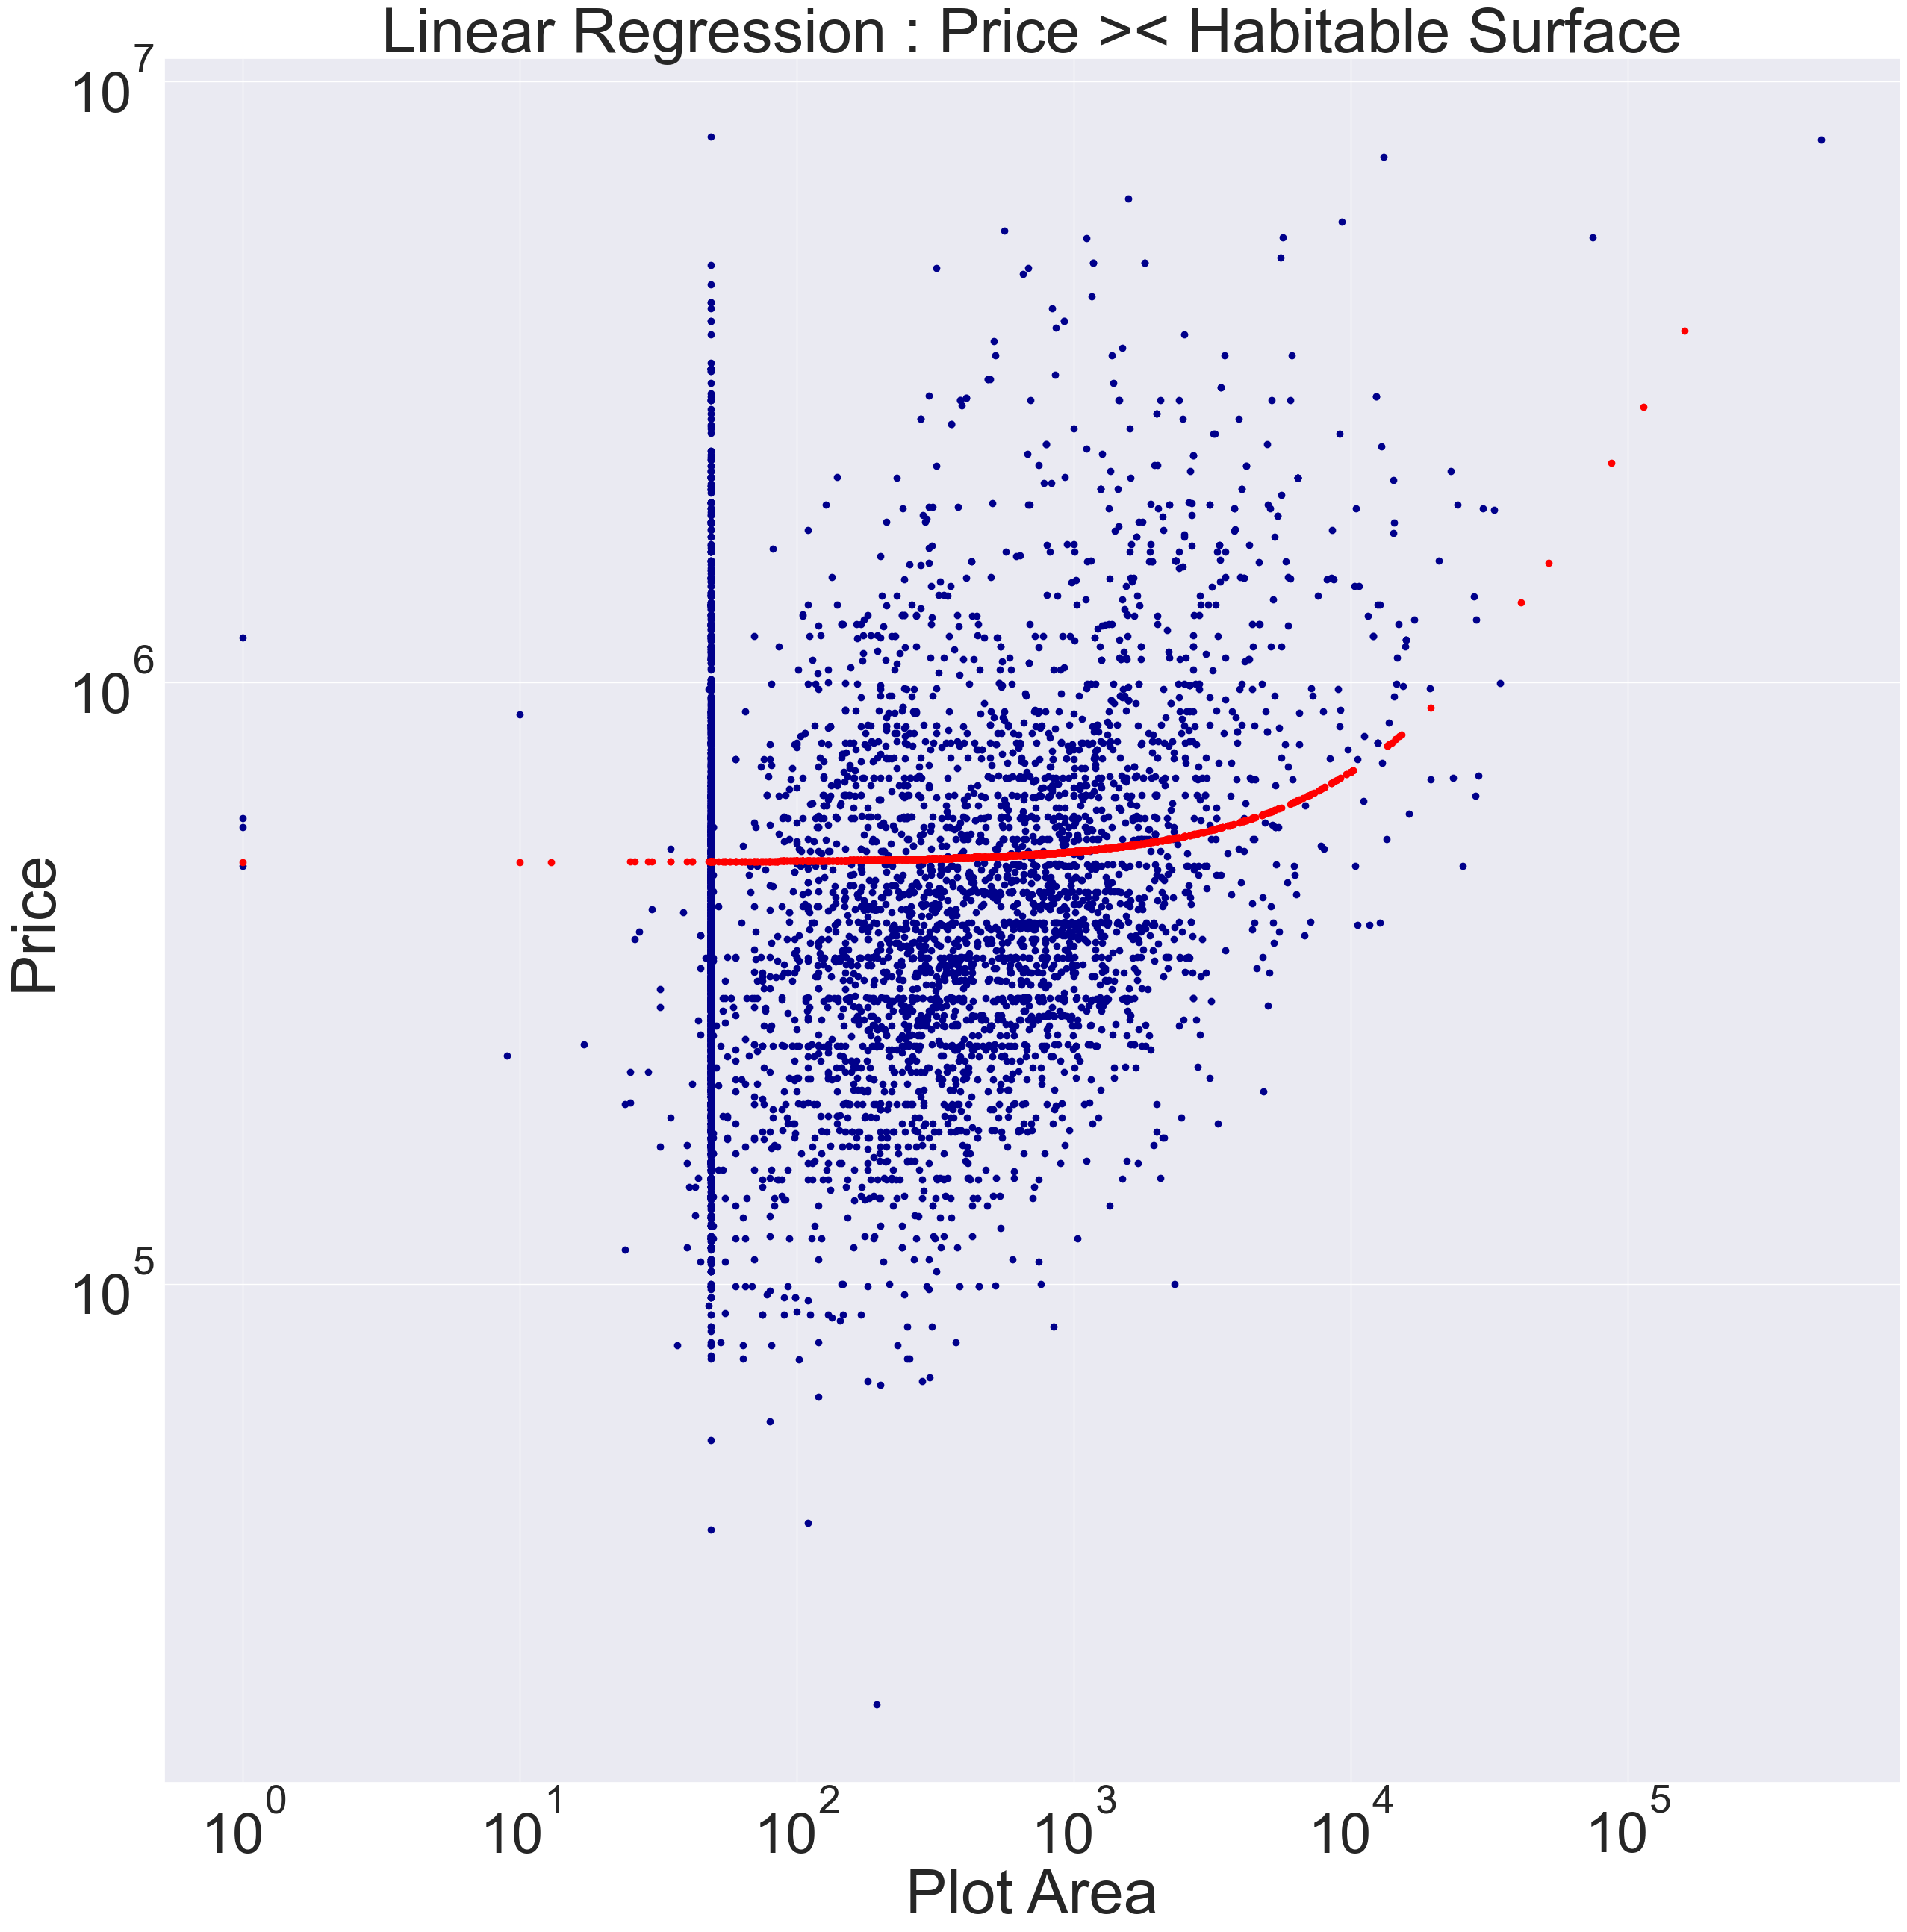

This Linear Regression Model is 4.179017398719931 percent accurate
After passing through 5-fold Cross Validation, this Linear Regression Model is -3.3716977071147847 percent accurate


In [348]:
X_habitable = X[:,3].reshape(-1,1)
y_true = y_true

# preliminary scater plot
sns.set_theme(style="whitegrid", palette="pastel")
sns.set(rc={"figure.figsize":(30,30)})
sns.set(font_scale=5)
sns.regplot(x=X_habitable, y=y_true, line_kws={'color':'black'})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Habitable Surface")
plt.ylabel("Price")
plt.title("Price >< Habitable Surface - Preliminary Scatterplot")
plt.show()

#splitting data
X_train, X_test, y_train, y_test = train_test_split(X_habitable, y_true, test_size=0.30, random_state=42, shuffle=True)

## fitting training
reg = LinearRegression()
reg.fit(X_train, y_train)

# testing model
X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_pred = reg.predict(X_test)

# visualize predictions
plt.scatter(X_train, y_train, color="darkblue")
plt.scatter(X_test, y_pred, color="red")
plt.title("Linear Regression : Price >< Habitable Surface")
plt.xlabel("Plot Area")
plt.ylabel("Price")
plt.xscale("log")
plt.yscale("log")
plt.show()

# EVALUATION
r_squared_score = reg.score(X_test, y_test)

print(f"This Linear Regression Model is {r_squared_score*100} percent accurate")

## N-fold Cross-Validation
cv_fold = 5
cv_result_mean = np.mean(cross_val_score(reg, X_habitable, y_true, cv=cv_fold))
print(f"After passing through {cv_fold}-fold Cross Validation, this Linear Regression Model is {cv_result_mean*100} percent accurate")


### REGULARIZING THE LINEAR REGRESSION MODEL USING CROSS-VALIDATED RIDGE REGRESSION

Best alpha: 10.0
Ridge score: 0.041766321949577634


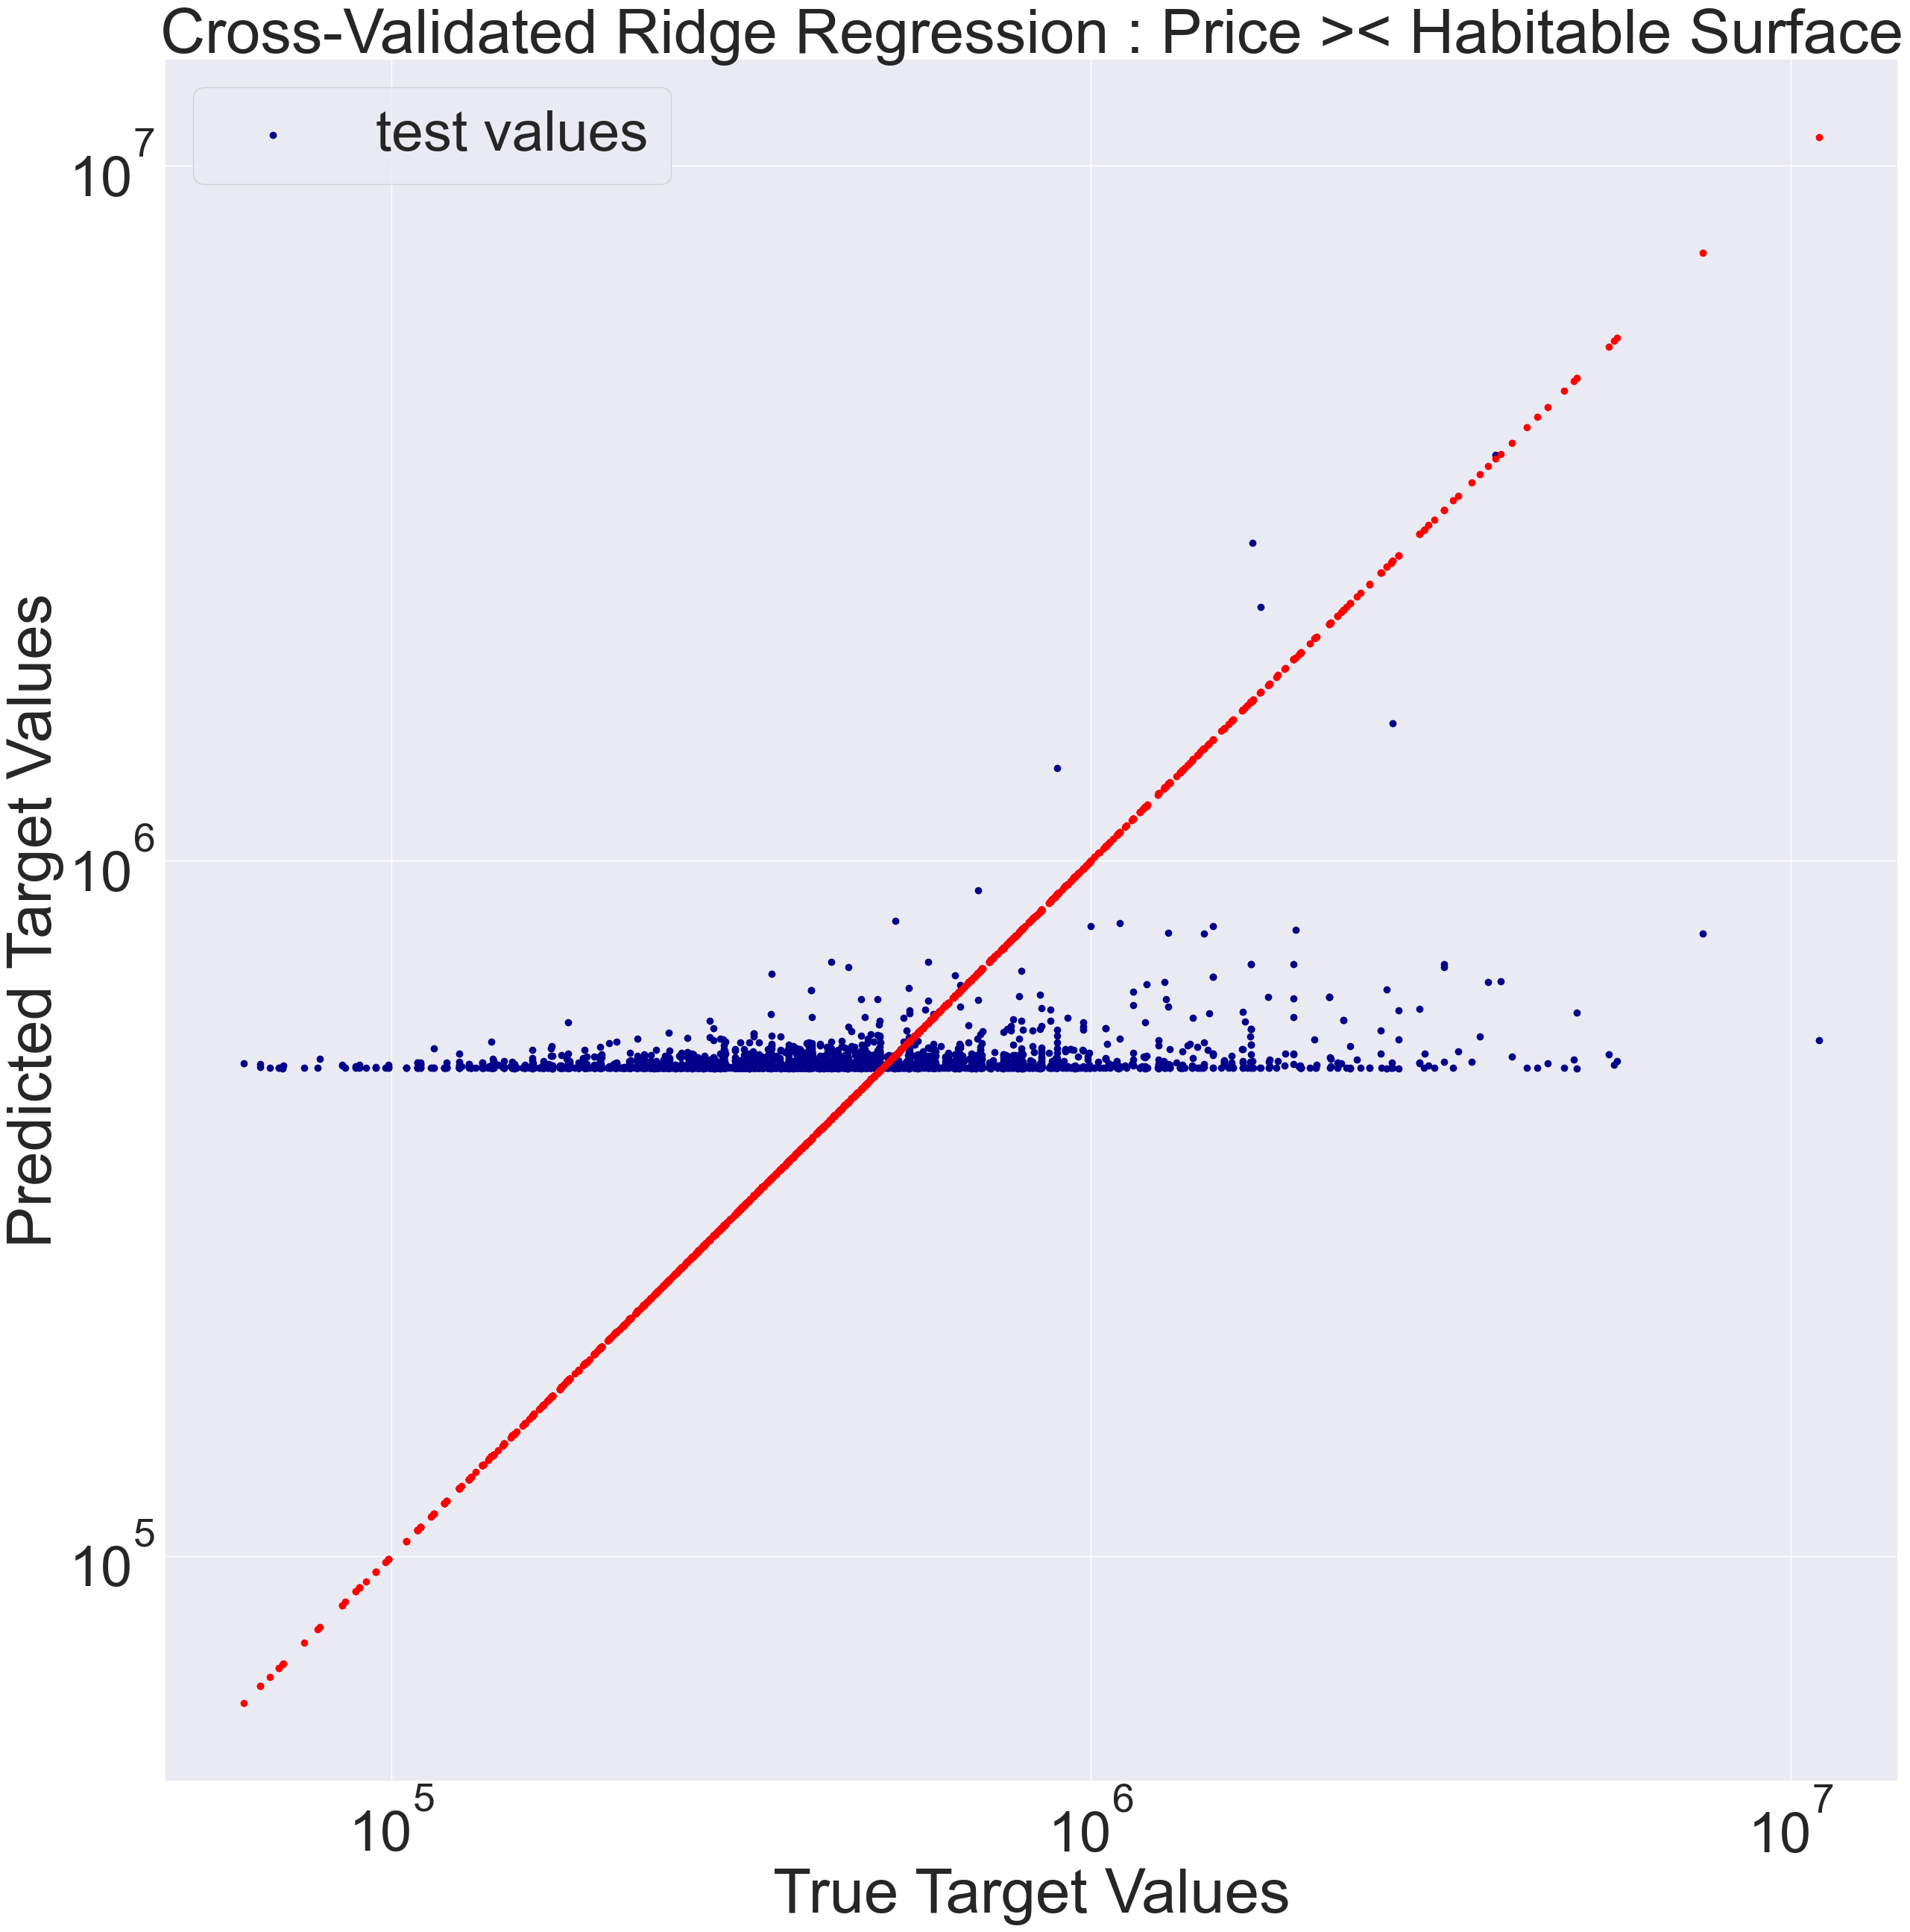

In [350]:
# Custom estimator to wrap RidgeCV
class RidgeCVWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=[0.1], cv=None):
        self.ridge_cv = RidgeCV(alphas=alphas, cv=cv)

    def fit(self, X, y):
        self.ridge_cv.fit(X, y)
        return self

    def predict(self, X):
        return self.ridge_cv.predict(X)

# Create the pipeline with the custom estimator
cv_fold = 6
ridge_pipeline = make_pipeline(
    StandardScaler(),                   # Normalize the data
    RidgeCVWrapper(alphas=[0.1, 1.0, 10.0], cv=cv_fold)   # Perform cross-validated ridge regression
)

# Fit the pipeline to the training data
ridge_pipeline.fit(X_train, y_train)

# Predict on the test data
ridged_y_pred = ridge_pipeline.predict(X_test)

# Get the best alpha value from the cross-validation
best_alpha = ridge_pipeline.named_steps['ridgecvwrapper'].ridge_cv.alpha_

# Get the score of the best ridge model
ridged_score = ridge_pipeline.score(X_test, y_test)

print(f"Best alpha: {best_alpha}")
print(f"Ridge score: {ridged_score}")


# VISUALIZE PREDICTION

plt.scatter(y_test, ridged_y_pred, color='darkblue', label='test values')
plt.scatter(y_test, y_test, color='red')  # Diagonal line (perfect prediction)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Cross-Validated Ridge Regression : Price >< Habitable Surface')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



In [ ]:
# import HuberRegressor

from sklearn.linear_model import HuberRegressor

Let's see what happened if we remove the outliers

In [ ]:
# # drop extreme values
# dataset_numerical.drop(dataset_numerical[dataset_numerical["price"] < 100000].index, inplace=True)
# dataset_numerical.drop(dataset_numerical[dataset_numerical["price"] > 3000000].index, inplace=True)
# dataset_numerical.drop(dataset_numerical[dataset_numerical["habitable_surface"] == 0].index, inplace=True)

## MULTIVARIABLE RANSACRegressor using HuberRegressor as 

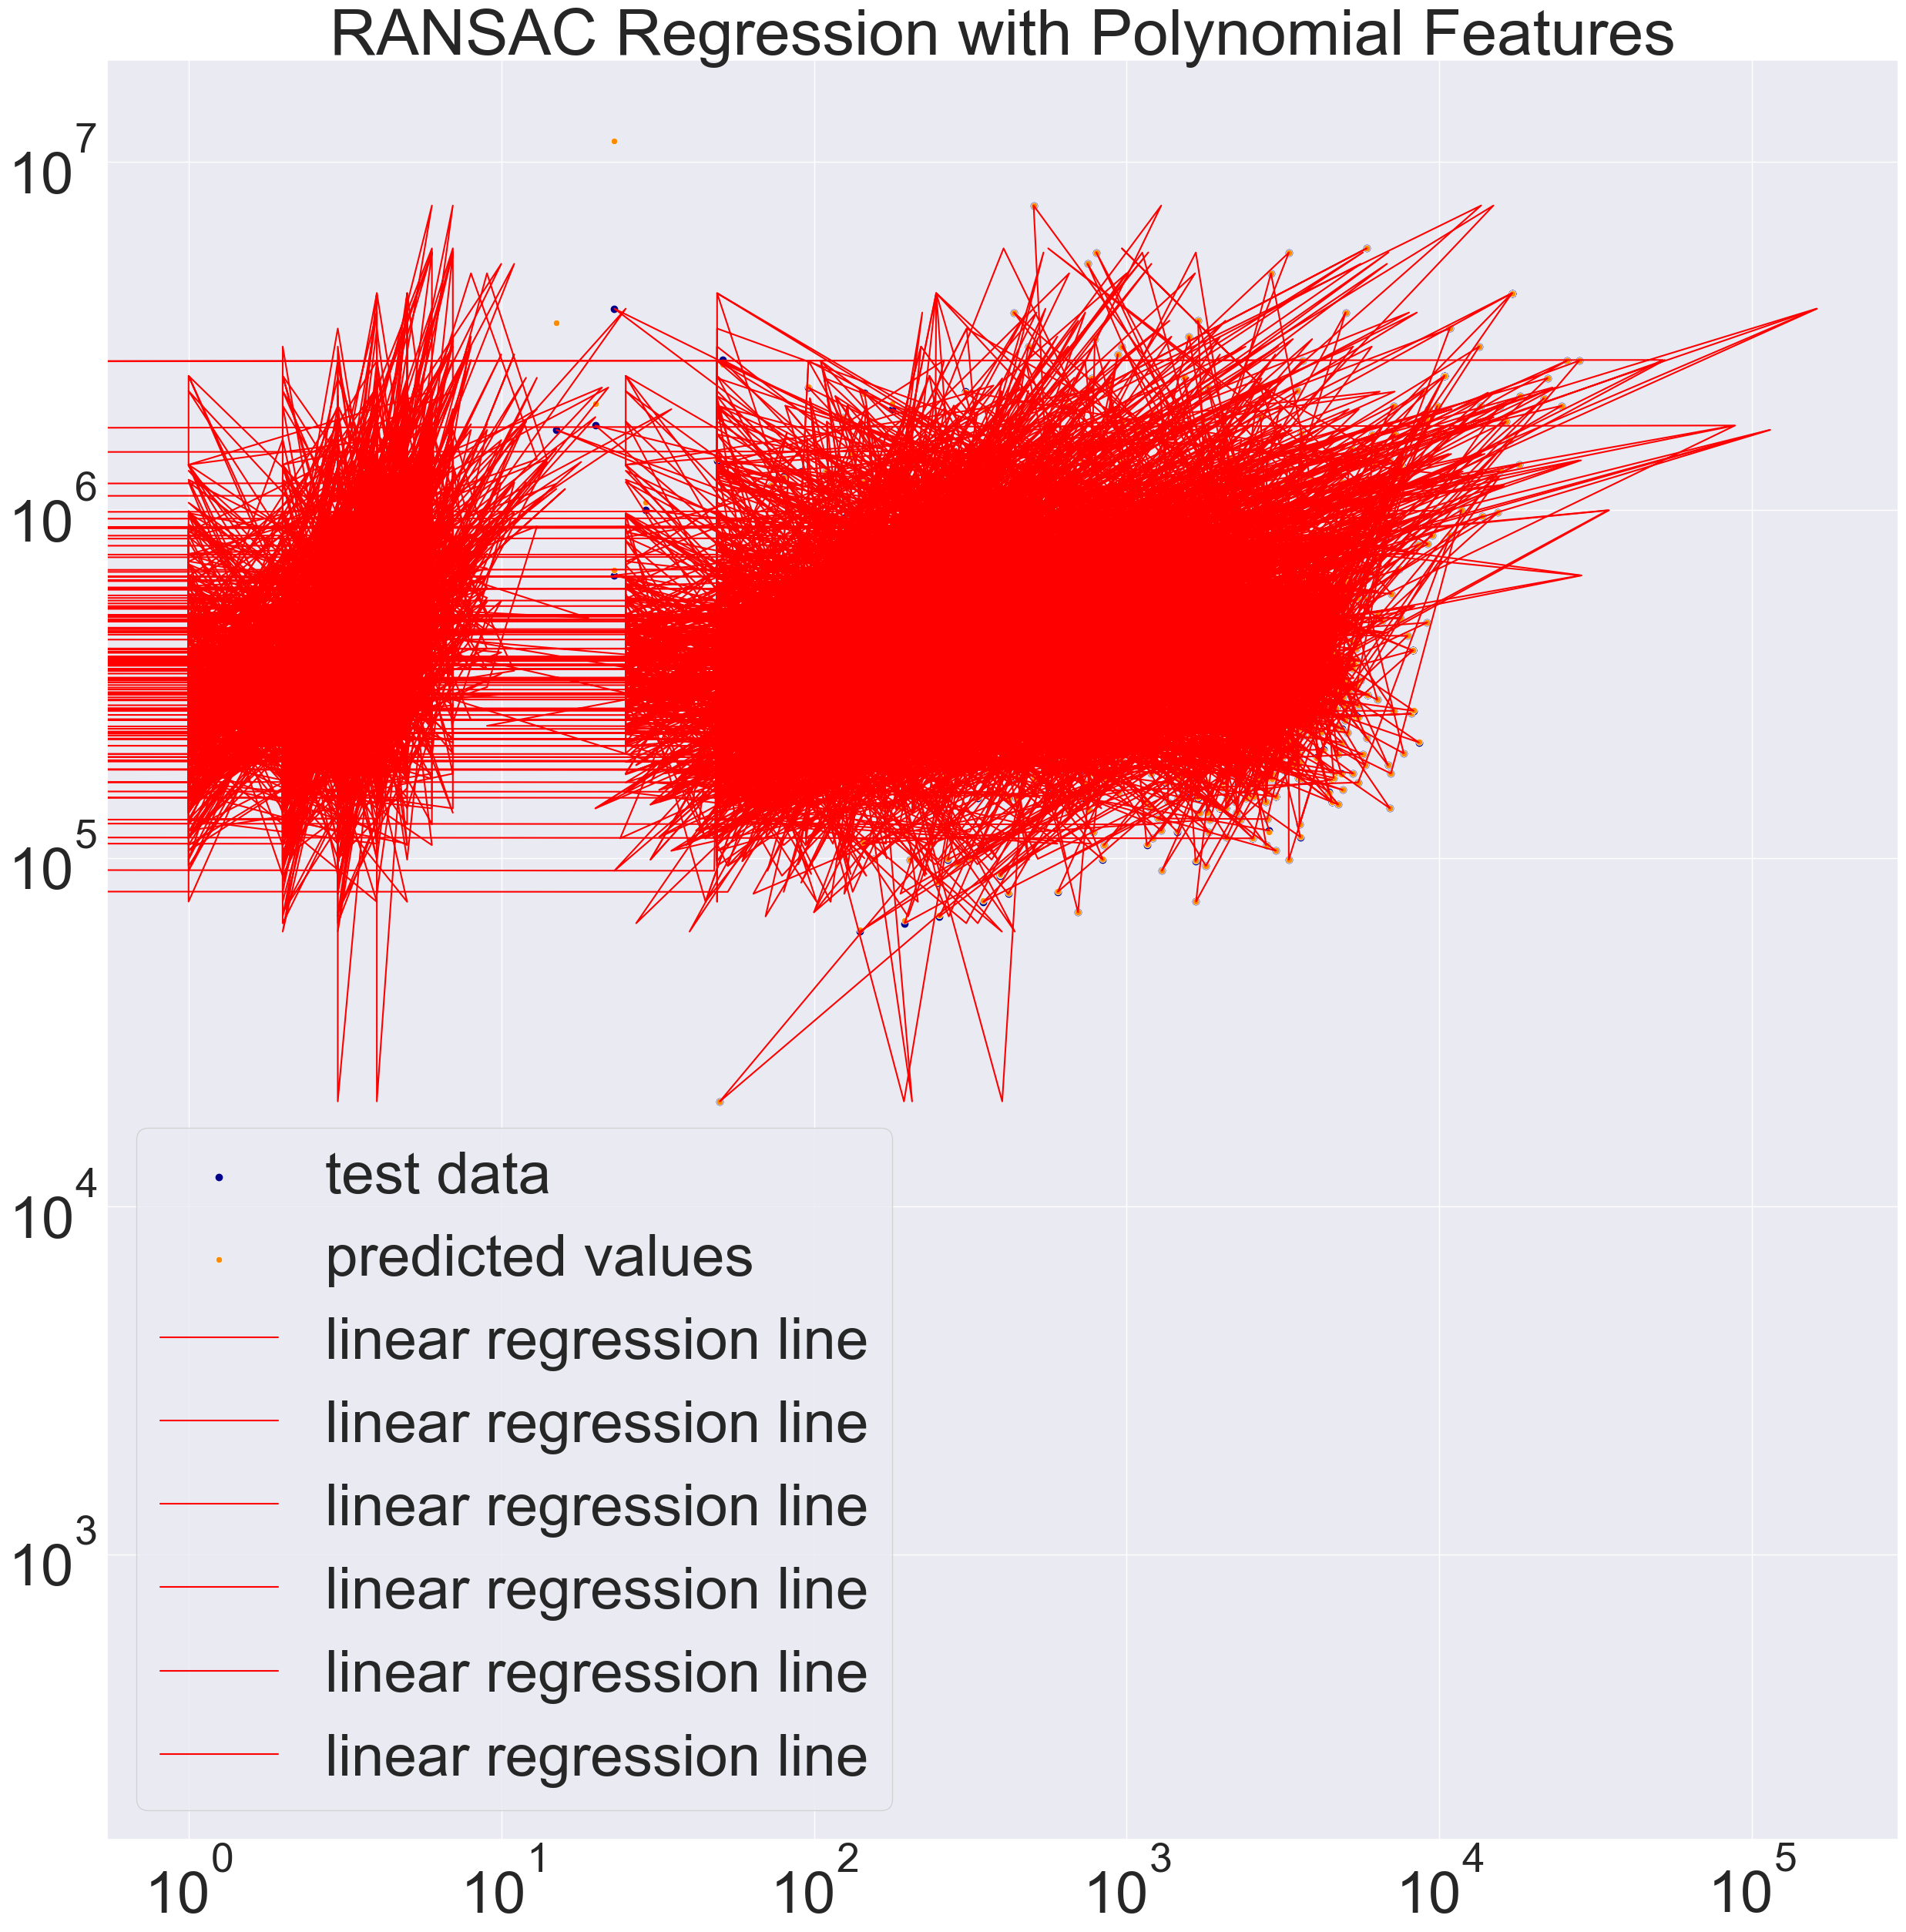

This RANSAC Regression Model is 82.32359624693166 percent accurate
After passing through 2-fold Cross Validation, this RANSAC Regression Model is -8408124765165158.0 percent accurate


In [354]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# variables to use
X = dataset_numerical.drop("price", axis=1).values
y = dataset_numerical["price"].values

# TRAINING MODEL

## Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Create the pipeline
ransac_pipe = make_pipeline(
    PolynomialFeatures(degree=3),  # Change degree to your desired polynomial degree
    StandardScaler(),
    RANSACRegressor(random_state=42)
)

# Fit the pipeline
ransac_pipe.fit(X_train, y_train)

# Testing model
y_pred = ransac_pipe.predict(X_test)

# reshape test variables
# X_test = X_test.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

# Reshape predicted values
y_pred_reshaped = y_pred.reshape(-1, 1)

# Visualize predictions
plt.scatter(X_test[:, 0], y_test, color="darkblue", label="test data")
sns.scatterplot(x=X_test[:, 0], y=y_pred, color="darkorange", label="predicted values")
plt.plot(X_test, y_test, color="red", label="linear regression line")
plt.title("RANSAC Regression with Polynomial Features")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


# Evaluation
r_squared_score = ransac_pipe.score(X_test, y_test)
print(f"This RANSAC Regression Model is {r_squared_score*100} percent accurate")

# N-fold Cross-Validation
cv_fold = 2
cv_result_mean = np.mean(cross_val_score(ransac_pipe, X, y, cv=cv_fold))
print(f"After passing through {cv_fold}-fold Cross Validation, this RANSAC Regression Model is {cv_result_mean*100} percent accurate")
